{'n_cars': 8792, 'n_notcars': 9666, 'data_type': dtype('float32'), 'image_shape': (64, 64, 3)}


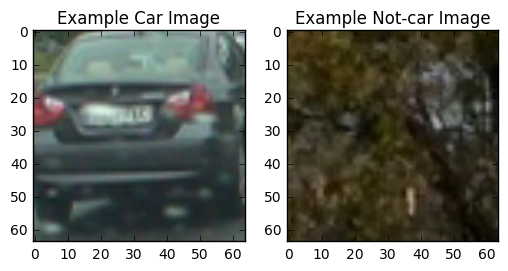

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import svm
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

cars = []
notcars = []

images_nonveh = glob.glob('non-vehicles/*/*.png')
images_veh = glob.glob('vehicles/*/*.png')
for image in images_nonveh:

    notcars.append(image)
    
for image in images_veh:
    cars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)
print(data_info)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    color1 = cv2.resize(img[: , : , 0], size).ravel()
    color2 = cv2.resize(img[: , : , 1], size).ravel()
    color3 = cv2.resize(img[: , : , 2], size).ravel()
    # Use cv2.resize().ravel() to create the feature vector
    # Return the feature vector
    return np.hstack((color1,color2,color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
   
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                                     hist_bins=32,orient=9, 
                                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                    spatial_feat=True,hist_feat=True,hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features= []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:

        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,thresh=0.70):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
       
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        dec_threshold=thresh
        dec = clf.decision_function(test_features)
        prediction = int(dec > dec_threshold)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] =  np.int(img.shape[0]/2)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap="hot")
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])






In [3]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#project_video ,pj2 is HSV
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
#y_start_stop = [image.shape[0]//2,image.shape[0]]


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(np.shape(X))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)
#svc = svm.SVC(kernel = "rbf")
#rfc = RandomForestClassifier()
#eclf = VotingClassifier(estimators=[
#         ('svc', svc), ('rfc', rfc)], voting='hard')


# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)
#eclf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
#print('Test Accuracy of SVC = ', round(eclf.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

(18458, 5520)
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
22.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9946


In [4]:
import pickle 
import os

dest = os.path.join("classifier")
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(svc,open(os.path.join(dest,"classifier.pkl"),"wb"))

In [5]:
import pickle 
import os
clf = pickle.load(open(os.path.join("classifier","classifier.pkl"),"rb"))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9946


3218


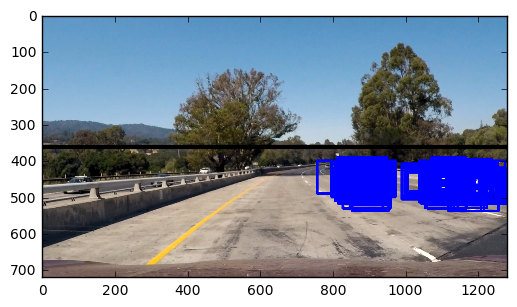

In [6]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
y_start_stop =[400,656]
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows1 = slide_window(image, x_start_stop=[900, 1200], y_start_stop=[360,480], 
                    xy_window=(64, 64), xy_overlap=(0.91, 0.91))
windows5 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[390,460], 
                    xy_window=(70, 70), xy_overlap=(0.90, 0.90))
windows2 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,500], 
                    xy_window=(90, 90), xy_overlap=(0.91, 0.91))
windows3 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))
windows4 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(110, 110), xy_overlap=(0.8, 0.8))

windows = windows1+windows2+windows3+windows4+windows5
print(len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,thresh=0.20)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)      
#print(np.shape(window_img))

plt.imshow(window_img)
plt.hlines(y=360,xmin=0,xmax=1280,lw=3)

In [7]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
    
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)> 30) & (np.max(nonzerox)-np.min(nonzerox)> 30)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            print("Car Number,",car_number,"Middle X",(bbox[0][0]+bbox[1][0])//2,"Middle Y",(bbox[0][1]+bbox[1][1])//2)
            
        # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img




Car Number, 1 Middle X 1132 Middle Y 451
Car Number, 2 Middle X 881 Middle Y 457


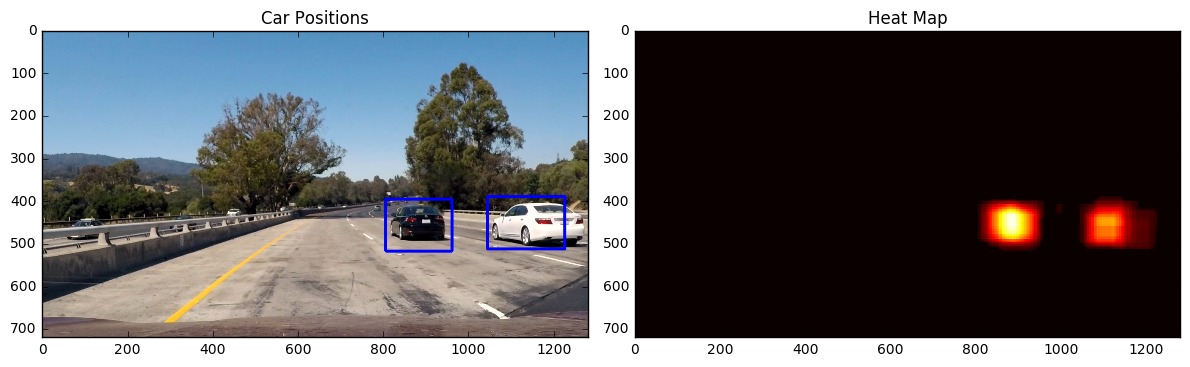

In [11]:
def pipeline_heatmap(img):


    # Read in image similar to one shown above 
    image = img.astype(np.float32)/255
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows1 = slide_window(image, x_start_stop=[900, 1200], y_start_stop=[360,480], 
                    xy_window=(64, 64), xy_overlap=(0.91, 0.91))
    windows5 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[360,460], 
                    xy_window=(70, 70), xy_overlap=(0.90, 0.90))
    windows2 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,500], 
                    xy_window=(90, 90), xy_overlap=(0.91, 0.91))
    windows3 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))
    windows4 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(110, 110), xy_overlap=(0.8, 0.8))

    windows = windows1+windows2+windows3+windows4+windows5
    #print(len(windows))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,thresh=0.7)               
    box_list= hot_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4.0)
    #project_output 1.0
    #project_output2 
    #project_output4 thresh=3.0
    #project_output5 thresh=5.0
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
   
    

    # Find final boxes from heatmap using label function
    labels= label(heatmap)
    
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    #plt.imshow(draw_img)
    return draw_img ,heatmap
    
img = mpimg.imread('test_images/test1.jpg')
draw_img,heatmap = pipeline_heatmap(img) 


fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
#plt.scatter(847,471,s=100)

plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [12]:
def pipeline_video(img):

    # Read in image similar to one shown above 
    image = img.astype(np.float32)/255
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows1 = slide_window(image, x_start_stop=[900, 1200], y_start_stop=[360,480], 
                    xy_window=(64, 64), xy_overlap=(0.91, 0.91))
    windows5 = slide_window(image, x_start_stop=[800, 1200], y_start_stop=[360,460], 
                    xy_window=(70, 70), xy_overlap=(0.90, 0.90))
    windows2 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,500], 
                    xy_window=(90, 90), xy_overlap=(0.91, 0.91))
    windows3 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(100, 100), xy_overlap=(0.8, 0.8))
    windows4 = slide_window(image, x_start_stop=[700, 1260], y_start_stop=[400,600], 
                    xy_window=(110, 110), xy_overlap=(0.8, 0.8))

    windows = windows1+windows2+windows3+windows4+windows5
    #print(len(windows))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat,thresh=0.7)               
    box_list= hot_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4.0)
    #project_output 1.0
    #project_output2 
    #project_output4 thresh=3.0
    #project_output5 thresh=5.0
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
   
    

    # Find final boxes from heatmap using label function
    labels= label(heatmap)
    
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    
    return draw_img



In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'test_short1.mp4'

clip_project = VideoFileClip("test_video.mp4")
project_clip = clip_project.fl_image(pipeline_video) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

Car Number, 1 Middle X 869 Middle Y 452
Car Number, 2 Middle X 1048 Middle Y 452
[MoviePy] >>>> Building video test_short1.mp4
[MoviePy] Writing video test_short1.mp4


  3%|▎         | 1/39 [00:16<10:31, 16.63s/it]

Car Number, 1 Middle X 869 Middle Y 452
Car Number, 2 Middle X 1048 Middle Y 452


KeyboardInterrupt: 

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [16]:
project_output = 'project_output.mp4'

clip_project = VideoFileClip("project_video.mp4")
project_clip = clip_project.fl_image(pipeline_video) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output5.mp4
[MoviePy] Writing video project_output5.mp4


 10%|█         | 132/1261 [35:38<5:04:59, 16.21s/it]

Car Number, 1 Middle X 1204 Middle Y 512


 11%|█▏        | 142/1261 [38:20<5:03:11, 16.26s/it]

Car Number, 1 Middle X 1164 Middle Y 504


 13%|█▎        | 158/1261 [42:42<5:03:09, 16.49s/it]

Car Number, 1 Middle X 1235 Middle Y 461


 13%|█▎        | 159/1261 [42:59<5:01:49, 16.43s/it]

Car Number, 1 Middle X 1229 Middle Y 470


 13%|█▎        | 160/1261 [43:15<5:00:48, 16.39s/it]

Car Number, 1 Middle X 1224 Middle Y 464


 13%|█▎        | 161/1261 [43:31<4:59:59, 16.36s/it]

Car Number, 1 Middle X 1225 Middle Y 462


 13%|█▎        | 162/1261 [43:48<4:59:33, 16.35s/it]

Car Number, 1 Middle X 1220 Middle Y 458


 13%|█▎        | 163/1261 [44:04<4:58:58, 16.34s/it]

Car Number, 1 Middle X 1216 Middle Y 468


 13%|█▎        | 164/1261 [44:20<4:58:34, 16.33s/it]

Car Number, 1 Middle X 1221 Middle Y 459


 13%|█▎        | 165/1261 [44:37<4:58:16, 16.33s/it]

Car Number, 1 Middle X 1216 Middle Y 464


 13%|█▎        | 166/1261 [44:53<4:58:20, 16.35s/it]

Car Number, 1 Middle X 1213 Middle Y 460


 13%|█▎        | 167/1261 [45:09<4:58:03, 16.35s/it]

Car Number, 1 Middle X 1208 Middle Y 460


 13%|█▎        | 168/1261 [45:26<4:57:41, 16.34s/it]

Car Number, 1 Middle X 1208 Middle Y 460


 13%|█▎        | 169/1261 [45:42<4:57:26, 16.34s/it]

Car Number, 1 Middle X 1199 Middle Y 455


 13%|█▎        | 170/1261 [45:58<4:57:16, 16.35s/it]

Car Number, 1 Middle X 1199 Middle Y 455


 14%|█▎        | 171/1261 [46:15<4:56:39, 16.33s/it]

Car Number, 1 Middle X 1196 Middle Y 451


 14%|█▎        | 172/1261 [46:31<4:56:20, 16.33s/it]

Car Number, 1 Middle X 1192 Middle Y 455


 14%|█▎        | 173/1261 [46:47<4:56:10, 16.33s/it]

Car Number, 1 Middle X 1188 Middle Y 453


 14%|█▍        | 174/1261 [47:04<4:56:08, 16.35s/it]

Car Number, 1 Middle X 1195 Middle Y 449


 14%|█▍        | 175/1261 [47:20<4:55:56, 16.35s/it]

Car Number, 1 Middle X 1183 Middle Y 453


 14%|█▍        | 176/1261 [47:36<4:55:46, 16.36s/it]

Car Number, 1 Middle X 1189 Middle Y 449


 14%|█▍        | 177/1261 [47:53<4:55:17, 16.34s/it]

Car Number, 1 Middle X 1178 Middle Y 455


 14%|█▍        | 178/1261 [48:09<4:55:00, 16.34s/it]

Car Number, 1 Middle X 1177 Middle Y 455


 14%|█▍        | 179/1261 [48:26<4:55:00, 16.36s/it]

Car Number, 1 Middle X 1172 Middle Y 459


 14%|█▍        | 180/1261 [48:42<4:54:37, 16.35s/it]

Car Number, 1 Middle X 1172 Middle Y 453


 14%|█▍        | 181/1261 [48:58<4:53:39, 16.31s/it]

Car Number, 1 Middle X 1176 Middle Y 444


 14%|█▍        | 182/1261 [49:14<4:52:58, 16.29s/it]

Car Number, 1 Middle X 1176 Middle Y 444


 15%|█▍        | 183/1261 [49:31<4:52:25, 16.28s/it]

Car Number, 1 Middle X 1169 Middle Y 447


 15%|█▍        | 184/1261 [49:47<4:52:01, 16.27s/it]

Car Number, 1 Middle X 1169 Middle Y 449


 15%|█▍        | 185/1261 [50:03<4:51:54, 16.28s/it]

Car Number, 1 Middle X 1171 Middle Y 444


 15%|█▍        | 186/1261 [50:19<4:51:43, 16.28s/it]

Car Number, 1 Middle X 1168 Middle Y 451


 15%|█▍        | 187/1261 [50:36<4:51:54, 16.31s/it]

Car Number, 1 Middle X 1168 Middle Y 451


 15%|█▍        | 188/1261 [50:52<4:52:14, 16.34s/it]

Car Number, 1 Middle X 1161 Middle Y 455


 15%|█▍        | 189/1261 [51:09<4:51:54, 16.34s/it]

Car Number, 1 Middle X 1161 Middle Y 455


 15%|█▌        | 190/1261 [51:25<4:51:48, 16.35s/it]

Car Number, 1 Middle X 1161 Middle Y 459


 15%|█▌        | 191/1261 [51:41<4:51:41, 16.36s/it]

Car Number, 1 Middle X 1158 Middle Y 451


 15%|█▌        | 192/1261 [51:58<4:51:33, 16.36s/it]

Car Number, 1 Middle X 1160 Middle Y 455


 15%|█▌        | 193/1261 [52:14<4:51:07, 16.36s/it]

Car Number, 1 Middle X 1158 Middle Y 454


 15%|█▌        | 194/1261 [52:30<4:50:33, 16.34s/it]

Car Number, 1 Middle X 1156 Middle Y 454


 15%|█▌        | 195/1261 [52:47<4:50:03, 16.33s/it]

Car Number, 1 Middle X 1152 Middle Y 451


 16%|█▌        | 196/1261 [53:03<4:49:34, 16.31s/it]

Car Number, 1 Middle X 1152 Middle Y 449


 16%|█▌        | 197/1261 [53:19<4:49:13, 16.31s/it]

Car Number, 1 Middle X 1156 Middle Y 446


 16%|█▌        | 198/1261 [53:35<4:48:53, 16.31s/it]

Car Number, 1 Middle X 1151 Middle Y 446


 16%|█▌        | 199/1261 [53:52<4:48:34, 16.30s/it]

Car Number, 1 Middle X 1148 Middle Y 449


 16%|█▌        | 200/1261 [54:08<4:48:16, 16.30s/it]

Car Number, 1 Middle X 1144 Middle Y 448


 16%|█▌        | 201/1261 [54:24<4:47:58, 16.30s/it]

Car Number, 1 Middle X 1146 Middle Y 448


 16%|█▌        | 202/1261 [54:41<4:47:34, 16.29s/it]

Car Number, 1 Middle X 1145 Middle Y 452


 16%|█▌        | 203/1261 [54:57<4:47:21, 16.30s/it]

Car Number, 1 Middle X 1170 Middle Y 455


 16%|█▌        | 204/1261 [55:13<4:48:12, 16.36s/it]

Car Number, 1 Middle X 1139 Middle Y 454


 16%|█▋        | 205/1261 [55:30<4:47:47, 16.35s/it]

Car Number, 1 Middle X 1147 Middle Y 455


 16%|█▋        | 206/1261 [55:46<4:47:13, 16.34s/it]

Car Number, 1 Middle X 1170 Middle Y 448


 16%|█▋        | 207/1261 [56:02<4:47:07, 16.34s/it]

Car Number, 1 Middle X 1166 Middle Y 451


 16%|█▋        | 208/1261 [56:19<4:46:53, 16.35s/it]

Car Number, 1 Middle X 1143 Middle Y 456


 17%|█▋        | 209/1261 [56:35<4:46:30, 16.34s/it]

Car Number, 1 Middle X 1165 Middle Y 449


 17%|█▋        | 210/1261 [56:51<4:46:17, 16.34s/it]

Car Number, 1 Middle X 1168 Middle Y 451


 17%|█▋        | 211/1261 [57:08<4:44:59, 16.29s/it]

Car Number, 1 Middle X 1136 Middle Y 447


 17%|█▋        | 212/1261 [57:25<4:48:07, 16.48s/it]

Car Number, 1 Middle X 1134 Middle Y 449


 17%|█▋        | 213/1261 [57:41<4:47:11, 16.44s/it]

Car Number, 1 Middle X 1135 Middle Y 447


 17%|█▋        | 214/1261 [57:57<4:46:21, 16.41s/it]

Car Number, 1 Middle X 1160 Middle Y 449


 17%|█▋        | 215/1261 [58:13<4:45:07, 16.36s/it]

Car Number, 1 Middle X 1156 Middle Y 451


 17%|█▋        | 216/1261 [58:30<4:44:29, 16.33s/it]

Car Number, 1 Middle X 1156 Middle Y 451


 17%|█▋        | 217/1261 [58:46<4:43:57, 16.32s/it]

Car Number, 1 Middle X 1160 Middle Y 451


 17%|█▋        | 218/1261 [59:02<4:43:33, 16.31s/it]

Car Number, 1 Middle X 1124 Middle Y 451


 17%|█▋        | 219/1261 [59:19<4:43:03, 16.30s/it]

Car Number, 1 Middle X 1128 Middle Y 449


 17%|█▋        | 220/1261 [59:35<4:42:41, 16.29s/it]

Car Number, 1 Middle X 1152 Middle Y 449


 18%|█▊        | 221/1261 [59:51<4:42:15, 16.28s/it]

Car Number, 1 Middle X 1155 Middle Y 446


 18%|█▊        | 222/1261 [1:00:07<4:42:02, 16.29s/it]

Car Number, 1 Middle X 1152 Middle Y 449


 18%|█▊        | 223/1261 [1:00:24<4:41:51, 16.29s/it]

Car Number, 1 Middle X 1156 Middle Y 451


 18%|█▊        | 224/1261 [1:00:40<4:41:28, 16.29s/it]

Car Number, 1 Middle X 1152 Middle Y 451


 18%|█▊        | 225/1261 [1:00:56<4:41:40, 16.31s/it]

Car Number, 1 Middle X 1123 Middle Y 451


 18%|█▊        | 226/1261 [1:01:13<4:41:27, 16.32s/it]

Car Number, 1 Middle X 1127 Middle Y 454


 18%|█▊        | 227/1261 [1:01:29<4:41:32, 16.34s/it]

Car Number, 1 Middle X 1152 Middle Y 451


 18%|█▊        | 228/1261 [1:01:45<4:41:08, 16.33s/it]

Car Number, 1 Middle X 1151 Middle Y 454


 18%|█▊        | 229/1261 [1:02:02<4:40:49, 16.33s/it]

Car Number, 1 Middle X 1156 Middle Y 451


 18%|█▊        | 230/1261 [1:02:18<4:40:19, 16.31s/it]

Car Number, 1 Middle X 1151 Middle Y 451


 18%|█▊        | 231/1261 [1:02:34<4:40:01, 16.31s/it]

Car Number, 1 Middle X 1146 Middle Y 451


 18%|█▊        | 232/1261 [1:02:51<4:39:46, 16.31s/it]

Car Number, 1 Middle X 1146 Middle Y 454


 18%|█▊        | 233/1261 [1:03:07<4:39:18, 16.30s/it]

Car Number, 1 Middle X 1146 Middle Y 451


 19%|█▊        | 234/1261 [1:03:23<4:38:59, 16.30s/it]

Car Number, 1 Middle X 1148 Middle Y 454


 19%|█▊        | 235/1261 [1:03:40<4:38:36, 16.29s/it]

Car Number, 1 Middle X 1145 Middle Y 451


 19%|█▊        | 236/1261 [1:03:56<4:38:30, 16.30s/it]

Car Number, 1 Middle X 1143 Middle Y 454


 19%|█▉        | 237/1261 [1:04:12<4:38:19, 16.31s/it]

Car Number, 1 Middle X 1104 Middle Y 451


 19%|█▉        | 238/1261 [1:04:28<4:38:12, 16.32s/it]

Car Number, 1 Middle X 1136 Middle Y 451


 19%|█▉        | 239/1261 [1:04:45<4:38:14, 16.34s/it]

Car Number, 1 Middle X 1139 Middle Y 454


 19%|█▉        | 240/1261 [1:05:01<4:37:52, 16.33s/it]

Car Number, 1 Middle X 1137 Middle Y 454


 19%|█▉        | 241/1261 [1:05:17<4:37:06, 16.30s/it]

Car Number, 1 Middle X 1103 Middle Y 449


 19%|█▉        | 242/1261 [1:05:34<4:36:37, 16.29s/it]

Car Number, 1 Middle X 1124 Middle Y 449


 19%|█▉        | 243/1261 [1:05:50<4:36:26, 16.29s/it]

Car Number, 1 Middle X 1104 Middle Y 447
Car Number, 2 Middle X 1188 Middle Y 454


 19%|█▉        | 244/1261 [1:06:06<4:36:09, 16.29s/it]

Car Number, 1 Middle X 1132 Middle Y 449


 19%|█▉        | 245/1261 [1:06:23<4:35:51, 16.29s/it]

Car Number, 1 Middle X 1131 Middle Y 449


 20%|█▉        | 246/1261 [1:06:39<4:35:51, 16.31s/it]

Car Number, 1 Middle X 1130 Middle Y 449


 20%|█▉        | 247/1261 [1:06:55<4:35:46, 16.32s/it]

Car Number, 1 Middle X 1129 Middle Y 451


 20%|█▉        | 248/1261 [1:07:12<4:35:42, 16.33s/it]

Car Number, 1 Middle X 1124 Middle Y 449


 20%|█▉        | 249/1261 [1:07:28<4:35:41, 16.35s/it]

Car Number, 1 Middle X 1116 Middle Y 451


 20%|█▉        | 250/1261 [1:07:44<4:35:35, 16.36s/it]

Car Number, 1 Middle X 1094 Middle Y 451


 20%|█▉        | 251/1261 [1:08:01<4:35:15, 16.35s/it]

Car Number, 1 Middle X 1140 Middle Y 455


 20%|█▉        | 252/1261 [1:08:17<4:34:56, 16.35s/it]

Car Number, 1 Middle X 1094 Middle Y 446


 20%|██        | 253/1261 [1:08:33<4:34:47, 16.36s/it]

Car Number, 1 Middle X 1128 Middle Y 451


 20%|██        | 254/1261 [1:08:50<4:34:18, 16.34s/it]

Car Number, 1 Middle X 1113 Middle Y 448


 20%|██        | 255/1261 [1:09:06<4:33:55, 16.34s/it]

Car Number, 1 Middle X 1132 Middle Y 451


 20%|██        | 256/1261 [1:09:22<4:33:39, 16.34s/it]

Car Number, 1 Middle X 1112 Middle Y 451


 20%|██        | 257/1261 [1:09:39<4:33:34, 16.35s/it]

Car Number, 1 Middle X 1112 Middle Y 451


 20%|██        | 258/1261 [1:09:55<4:33:21, 16.35s/it]

Car Number, 1 Middle X 1118 Middle Y 451


 21%|██        | 259/1261 [1:10:11<4:33:05, 16.35s/it]

Car Number, 1 Middle X 1119 Middle Y 451


 21%|██        | 260/1261 [1:10:28<4:32:44, 16.35s/it]

Car Number, 1 Middle X 1122 Middle Y 451


 21%|██        | 261/1261 [1:10:44<4:32:23, 16.34s/it]

Car Number, 1 Middle X 1118 Middle Y 451


 21%|██        | 262/1261 [1:11:00<4:31:59, 16.34s/it]

Car Number, 1 Middle X 1113 Middle Y 448


 21%|██        | 263/1261 [1:11:17<4:31:42, 16.33s/it]

Car Number, 1 Middle X 1119 Middle Y 449


 21%|██        | 264/1261 [1:11:33<4:31:38, 16.35s/it]

Car Number, 1 Middle X 1116 Middle Y 449


 21%|██        | 265/1261 [1:11:50<4:31:33, 16.36s/it]

Car Number, 1 Middle X 1120 Middle Y 447


 21%|██        | 266/1261 [1:12:06<4:32:55, 16.46s/it]

Car Number, 1 Middle X 1116 Middle Y 447


 21%|██        | 267/1261 [1:12:23<4:32:09, 16.43s/it]

Car Number, 1 Middle X 1125 Middle Y 451


 21%|██▏       | 268/1261 [1:12:39<4:31:28, 16.40s/it]

Car Number, 1 Middle X 1119 Middle Y 449


 21%|██▏       | 269/1261 [1:12:55<4:30:53, 16.38s/it]

Car Number, 1 Middle X 1126 Middle Y 447


 21%|██▏       | 270/1261 [1:13:12<4:30:19, 16.37s/it]

Car Number, 1 Middle X 1124 Middle Y 451


 21%|██▏       | 271/1261 [1:13:28<4:29:32, 16.34s/it]

Car Number, 1 Middle X 1117 Middle Y 451


 22%|██▏       | 272/1261 [1:13:44<4:28:57, 16.32s/it]

Car Number, 1 Middle X 1105 Middle Y 451


 22%|██▏       | 273/1261 [1:14:00<4:28:41, 16.32s/it]

Car Number, 1 Middle X 1109 Middle Y 451


 22%|██▏       | 274/1261 [1:14:17<4:28:28, 16.32s/it]

Car Number, 1 Middle X 1100 Middle Y 451


 22%|██▏       | 275/1261 [1:14:33<4:28:08, 16.32s/it]

Car Number, 1 Middle X 1110 Middle Y 459


 22%|██▏       | 276/1261 [1:14:49<4:27:54, 16.32s/it]

Car Number, 1 Middle X 1106 Middle Y 451


 22%|██▏       | 277/1261 [1:15:06<4:27:41, 16.32s/it]

Car Number, 1 Middle X 1106 Middle Y 451


 22%|██▏       | 278/1261 [1:15:22<4:27:33, 16.33s/it]

Car Number, 1 Middle X 1116 Middle Y 451


 22%|██▏       | 279/1261 [1:15:39<4:27:34, 16.35s/it]

Car Number, 1 Middle X 1114 Middle Y 456


 22%|██▏       | 280/1261 [1:15:55<4:27:12, 16.34s/it]

Car Number, 1 Middle X 1121 Middle Y 456


 22%|██▏       | 281/1261 [1:16:11<4:27:16, 16.36s/it]

Car Number, 1 Middle X 1120 Middle Y 451


 22%|██▏       | 282/1261 [1:16:28<4:27:07, 16.37s/it]

Car Number, 1 Middle X 1117 Middle Y 454


 22%|██▏       | 283/1261 [1:16:44<4:26:51, 16.37s/it]

Car Number, 1 Middle X 1116 Middle Y 451


 23%|██▎       | 284/1261 [1:17:00<4:26:48, 16.39s/it]

Car Number, 1 Middle X 1124 Middle Y 451


 23%|██▎       | 285/1261 [1:17:17<4:26:24, 16.38s/it]

Car Number, 1 Middle X 1124 Middle Y 451


 23%|██▎       | 286/1261 [1:17:33<4:26:09, 16.38s/it]

Car Number, 1 Middle X 1102 Middle Y 451


 23%|██▎       | 287/1261 [1:17:50<4:26:02, 16.39s/it]

Car Number, 1 Middle X 1110 Middle Y 451


 23%|██▎       | 288/1261 [1:18:06<4:25:39, 16.38s/it]

Car Number, 1 Middle X 1120 Middle Y 456


 23%|██▎       | 289/1261 [1:18:22<4:25:30, 16.39s/it]

Car Number, 1 Middle X 1123 Middle Y 451


 23%|██▎       | 290/1261 [1:18:39<4:25:10, 16.39s/it]

Car Number, 1 Middle X 1123 Middle Y 451


 23%|██▎       | 291/1261 [1:18:55<4:25:01, 16.39s/it]

Car Number, 1 Middle X 1122 Middle Y 451


 23%|██▎       | 292/1261 [1:19:12<4:24:52, 16.40s/it]

Car Number, 1 Middle X 1116 Middle Y 454


 23%|██▎       | 293/1261 [1:19:28<4:24:46, 16.41s/it]

Car Number, 1 Middle X 1116 Middle Y 456


 23%|██▎       | 294/1261 [1:19:44<4:24:25, 16.41s/it]

Car Number, 1 Middle X 1112 Middle Y 456


 23%|██▎       | 295/1261 [1:20:01<4:24:02, 16.40s/it]

Car Number, 1 Middle X 1115 Middle Y 454


 23%|██▎       | 296/1261 [1:20:17<4:23:52, 16.41s/it]

Car Number, 1 Middle X 1104 Middle Y 451


 24%|██▎       | 297/1261 [1:20:34<4:23:32, 16.40s/it]

Car Number, 1 Middle X 1108 Middle Y 451


 24%|██▎       | 298/1261 [1:20:50<4:23:09, 16.40s/it]

Car Number, 1 Middle X 1110 Middle Y 451


 24%|██▎       | 299/1261 [1:21:06<4:22:47, 16.39s/it]

Car Number, 1 Middle X 1110 Middle Y 456


 24%|██▍       | 300/1261 [1:21:23<4:22:30, 16.39s/it]

Car Number, 1 Middle X 1107 Middle Y 456


 24%|██▍       | 301/1261 [1:21:39<4:21:43, 16.36s/it]

Car Number, 1 Middle X 1056 Middle Y 452


 24%|██▍       | 302/1261 [1:21:55<4:21:11, 16.34s/it]

Car Number, 1 Middle X 1089 Middle Y 452


 24%|██▍       | 303/1261 [1:22:12<4:20:47, 16.33s/it]

Car Number, 1 Middle X 1089 Middle Y 452


 24%|██▍       | 304/1261 [1:22:28<4:20:33, 16.34s/it]

Car Number, 1 Middle X 1086 Middle Y 452


 24%|██▍       | 305/1261 [1:22:44<4:20:15, 16.33s/it]

Car Number, 1 Middle X 1084 Middle Y 452


 24%|██▍       | 306/1261 [1:23:01<4:20:10, 16.35s/it]

Car Number, 1 Middle X 1100 Middle Y 456


 24%|██▍       | 307/1261 [1:23:17<4:19:50, 16.34s/it]

Car Number, 1 Middle X 1052 Middle Y 454
Car Number, 2 Middle X 1161 Middle Y 466


 24%|██▍       | 308/1261 [1:23:33<4:19:27, 16.34s/it]

Car Number, 1 Middle X 1098 Middle Y 453


 25%|██▍       | 309/1261 [1:23:50<4:19:18, 16.34s/it]

Car Number, 1 Middle X 1056 Middle Y 457
Car Number, 2 Middle X 1161 Middle Y 464


 25%|██▍       | 310/1261 [1:24:06<4:19:00, 16.34s/it]

Car Number, 1 Middle X 1094 Middle Y 456


 25%|██▍       | 311/1261 [1:24:22<4:18:47, 16.34s/it]

Car Number, 1 Middle X 1095 Middle Y 454


 25%|██▍       | 312/1261 [1:24:39<4:18:33, 16.35s/it]

Car Number, 1 Middle X 1101 Middle Y 454


 25%|██▍       | 313/1261 [1:24:55<4:18:17, 16.35s/it]

Car Number, 1 Middle X 1100 Middle Y 459


 25%|██▍       | 314/1261 [1:25:11<4:18:14, 16.36s/it]

Car Number, 1 Middle X 1049 Middle Y 452
Car Number, 2 Middle X 1164 Middle Y 468


 25%|██▍       | 315/1261 [1:25:28<4:18:10, 16.37s/it]

Car Number, 1 Middle X 1064 Middle Y 454
Car Number, 2 Middle X 1170 Middle Y 466


 25%|██▌       | 316/1261 [1:25:44<4:17:51, 16.37s/it]

Car Number, 1 Middle X 1048 Middle Y 452
Car Number, 2 Middle X 1152 Middle Y 466


 25%|██▌       | 317/1261 [1:26:01<4:17:39, 16.38s/it]

Car Number, 1 Middle X 1101 Middle Y 457


 25%|██▌       | 318/1261 [1:26:17<4:17:31, 16.39s/it]

Car Number, 1 Middle X 1093 Middle Y 454


 25%|██▌       | 319/1261 [1:26:33<4:17:18, 16.39s/it]

Car Number, 1 Middle X 1044 Middle Y 453
Car Number, 2 Middle X 1155 Middle Y 466


 25%|██▌       | 320/1261 [1:26:50<4:17:15, 16.40s/it]

Car Number, 1 Middle X 1094 Middle Y 451


 25%|██▌       | 321/1261 [1:27:06<4:17:16, 16.42s/it]

Car Number, 1 Middle X 1075 Middle Y 452


 26%|██▌       | 322/1261 [1:27:23<4:17:02, 16.42s/it]

Car Number, 1 Middle X 1094 Middle Y 453


 26%|██▌       | 323/1261 [1:27:39<4:16:44, 16.42s/it]

Car Number, 1 Middle X 1042 Middle Y 450
Car Number, 2 Middle X 1152 Middle Y 466


 26%|██▌       | 324/1261 [1:27:56<4:16:19, 16.41s/it]

Car Number, 1 Middle X 1044 Middle Y 450


 26%|██▌       | 325/1261 [1:28:12<4:16:18, 16.43s/it]

Car Number, 1 Middle X 1047 Middle Y 450
Car Number, 2 Middle X 1140 Middle Y 464


 26%|██▌       | 326/1261 [1:28:28<4:15:53, 16.42s/it]

Car Number, 1 Middle X 1084 Middle Y 452


 26%|██▌       | 327/1261 [1:28:45<4:15:27, 16.41s/it]

Car Number, 1 Middle X 1084 Middle Y 452


 26%|██▌       | 328/1261 [1:29:01<4:14:59, 16.40s/it]

Car Number, 1 Middle X 1087 Middle Y 454


 26%|██▌       | 329/1261 [1:29:18<4:14:34, 16.39s/it]

Car Number, 1 Middle X 1087 Middle Y 453


 26%|██▌       | 330/1261 [1:29:34<4:14:18, 16.39s/it]

Car Number, 1 Middle X 1089 Middle Y 453


 26%|██▌       | 331/1261 [1:29:50<4:13:44, 16.37s/it]

Car Number, 1 Middle X 1047 Middle Y 456


 26%|██▋       | 332/1261 [1:30:07<4:13:18, 16.36s/it]

Car Number, 1 Middle X 1039 Middle Y 453


 26%|██▋       | 333/1261 [1:30:23<4:12:59, 16.36s/it]

Car Number, 1 Middle X 1073 Middle Y 460


 26%|██▋       | 334/1261 [1:30:39<4:12:51, 16.37s/it]

Car Number, 1 Middle X 1076 Middle Y 458


 27%|██▋       | 335/1261 [1:30:56<4:12:37, 16.37s/it]

Car Number, 1 Middle X 1044 Middle Y 454


 27%|██▋       | 336/1261 [1:31:12<4:12:29, 16.38s/it]

Car Number, 1 Middle X 1077 Middle Y 452


 27%|██▋       | 337/1261 [1:31:29<4:12:17, 16.38s/it]

Car Number, 1 Middle X 1032 Middle Y 452


 27%|██▋       | 338/1261 [1:31:45<4:11:53, 16.37s/it]

Car Number, 1 Middle X 1035 Middle Y 452
Car Number, 2 Middle X 1131 Middle Y 466


 27%|██▋       | 339/1261 [1:32:01<4:11:41, 16.38s/it]

Car Number, 1 Middle X 1068 Middle Y 456


 27%|██▋       | 340/1261 [1:32:18<4:11:35, 16.39s/it]

Car Number, 1 Middle X 1074 Middle Y 453


 27%|██▋       | 341/1261 [1:32:34<4:11:27, 16.40s/it]

Car Number, 1 Middle X 1074 Middle Y 456


 27%|██▋       | 342/1261 [1:32:51<4:11:13, 16.40s/it]

Car Number, 1 Middle X 1076 Middle Y 456


 27%|██▋       | 343/1261 [1:33:07<4:11:03, 16.41s/it]

Car Number, 1 Middle X 1070 Middle Y 453


 27%|██▋       | 344/1261 [1:33:23<4:10:41, 16.40s/it]

Car Number, 1 Middle X 1070 Middle Y 453


 27%|██▋       | 345/1261 [1:33:40<4:10:28, 16.41s/it]

Car Number, 1 Middle X 1074 Middle Y 456


 27%|██▋       | 346/1261 [1:33:56<4:10:12, 16.41s/it]

Car Number, 1 Middle X 1074 Middle Y 450


 28%|██▊       | 347/1261 [1:34:13<4:10:10, 16.42s/it]

Car Number, 1 Middle X 1070 Middle Y 454


 28%|██▊       | 348/1261 [1:34:29<4:10:40, 16.47s/it]

Car Number, 1 Middle X 1069 Middle Y 452


 28%|██▊       | 349/1261 [1:34:46<4:10:04, 16.45s/it]

Car Number, 1 Middle X 1065 Middle Y 452


 28%|██▊       | 350/1261 [1:35:02<4:09:38, 16.44s/it]

Car Number, 1 Middle X 1071 Middle Y 452


 28%|██▊       | 351/1261 [1:35:18<4:08:56, 16.41s/it]

Car Number, 1 Middle X 1068 Middle Y 452


 28%|██▊       | 352/1261 [1:35:35<4:08:27, 16.40s/it]

Car Number, 1 Middle X 1026 Middle Y 452


 28%|██▊       | 353/1261 [1:35:51<4:07:53, 16.38s/it]

Car Number, 1 Middle X 1062 Middle Y 452


 28%|██▊       | 354/1261 [1:36:08<4:07:52, 16.40s/it]

Car Number, 1 Middle X 1024 Middle Y 453
Car Number, 2 Middle X 1116 Middle Y 465


 28%|██▊       | 355/1261 [1:36:24<4:07:30, 16.39s/it]

Car Number, 1 Middle X 1060 Middle Y 452


 28%|██▊       | 356/1261 [1:36:40<4:07:21, 16.40s/it]

Car Number, 1 Middle X 1058 Middle Y 456


 28%|██▊       | 357/1261 [1:36:57<4:07:04, 16.40s/it]

Car Number, 1 Middle X 1061 Middle Y 453


 28%|██▊       | 358/1261 [1:37:13<4:06:34, 16.38s/it]

Car Number, 1 Middle X 1058 Middle Y 456


 28%|██▊       | 359/1261 [1:37:29<4:06:09, 16.37s/it]

Car Number, 1 Middle X 1054 Middle Y 450


 29%|██▊       | 360/1261 [1:37:46<4:05:51, 16.37s/it]

Car Number, 1 Middle X 1058 Middle Y 454


 29%|██▊       | 361/1261 [1:38:02<4:05:06, 16.34s/it]

Car Number, 1 Middle X 1013 Middle Y 448


 29%|██▊       | 362/1261 [1:38:18<4:04:39, 16.33s/it]

Car Number, 1 Middle X 1016 Middle Y 452


 29%|██▉       | 363/1261 [1:38:35<4:04:07, 16.31s/it]

Car Number, 1 Middle X 1058 Middle Y 454


 29%|██▉       | 364/1261 [1:38:51<4:04:03, 16.32s/it]

Car Number, 1 Middle X 1053 Middle Y 452


 29%|██▉       | 365/1261 [1:39:07<4:03:58, 16.34s/it]

Car Number, 1 Middle X 1012 Middle Y 452
Car Number, 2 Middle X 1099 Middle Y 463


 29%|██▉       | 366/1261 [1:39:24<4:03:51, 16.35s/it]

Car Number, 1 Middle X 1008 Middle Y 452


 29%|██▉       | 367/1261 [1:39:40<4:03:40, 16.35s/it]

Car Number, 1 Middle X 1051 Middle Y 450


 29%|██▉       | 368/1261 [1:39:57<4:03:42, 16.38s/it]

Car Number, 1 Middle X 1044 Middle Y 454


 29%|██▉       | 369/1261 [1:40:13<4:04:24, 16.44s/it]

Car Number, 1 Middle X 1050 Middle Y 456


 29%|██▉       | 370/1261 [1:40:30<4:03:57, 16.43s/it]

Car Number, 1 Middle X 1044 Middle Y 456


 29%|██▉       | 371/1261 [1:40:46<4:03:26, 16.41s/it]

Car Number, 1 Middle X 1205 Middle Y 418
Car Number, 2 Middle X 1040 Middle Y 457


 30%|██▉       | 372/1261 [1:41:02<4:03:03, 16.40s/it]

Car Number, 1 Middle X 1041 Middle Y 454


 30%|██▉       | 373/1261 [1:41:19<4:02:42, 16.40s/it]

Car Number, 1 Middle X 1041 Middle Y 456


 30%|██▉       | 374/1261 [1:41:35<4:02:36, 16.41s/it]

Car Number, 1 Middle X 1040 Middle Y 454


 30%|██▉       | 375/1261 [1:41:52<4:02:23, 16.42s/it]

Car Number, 1 Middle X 1041 Middle Y 454


 30%|██▉       | 376/1261 [1:42:08<4:02:07, 16.41s/it]

Car Number, 1 Middle X 1039 Middle Y 454


 30%|██▉       | 377/1261 [1:42:24<4:01:56, 16.42s/it]

Car Number, 1 Middle X 1038 Middle Y 454


 30%|██▉       | 378/1261 [1:42:41<4:01:59, 16.44s/it]

Car Number, 1 Middle X 1035 Middle Y 453


 30%|███       | 379/1261 [1:42:57<4:01:28, 16.43s/it]

Car Number, 1 Middle X 1032 Middle Y 457


 30%|███       | 380/1261 [1:43:14<4:02:38, 16.52s/it]

Car Number, 1 Middle X 1032 Middle Y 454


 30%|███       | 381/1261 [1:43:30<4:02:08, 16.51s/it]

Car Number, 1 Middle X 1024 Middle Y 452


 30%|███       | 382/1261 [1:43:47<4:01:27, 16.48s/it]

Car Number, 1 Middle X 1024 Middle Y 453


 30%|███       | 383/1261 [1:44:03<4:00:53, 16.46s/it]

Car Number, 1 Middle X 1029 Middle Y 452


 30%|███       | 384/1261 [1:44:20<4:00:20, 16.44s/it]

Car Number, 1 Middle X 1023 Middle Y 450


 31%|███       | 385/1261 [1:44:36<3:59:43, 16.42s/it]

Car Number, 1 Middle X 1027 Middle Y 450


 31%|███       | 386/1261 [1:44:52<3:59:10, 16.40s/it]

Car Number, 1 Middle X 1020 Middle Y 452


 31%|███       | 387/1261 [1:45:09<3:58:44, 16.39s/it]

Car Number, 1 Middle X 1019 Middle Y 449


 31%|███       | 388/1261 [1:45:25<3:58:28, 16.39s/it]

Car Number, 1 Middle X 1023 Middle Y 448


 31%|███       | 389/1261 [1:45:42<3:58:12, 16.39s/it]

Car Number, 1 Middle X 1020 Middle Y 449


 31%|███       | 390/1261 [1:45:58<3:57:50, 16.38s/it]

Car Number, 1 Middle X 1019 Middle Y 448


 31%|███       | 391/1261 [1:46:14<3:57:01, 16.35s/it]

Car Number, 1 Middle X 1012 Middle Y 448


 31%|███       | 392/1261 [1:46:31<3:56:31, 16.33s/it]

Car Number, 1 Middle X 1003 Middle Y 448


 31%|███       | 393/1261 [1:46:47<3:56:05, 16.32s/it]

Car Number, 1 Middle X 1007 Middle Y 449


 31%|███       | 394/1261 [1:47:03<3:55:53, 16.33s/it]

Car Number, 1 Middle X 1014 Middle Y 449


 31%|███▏      | 395/1261 [1:47:19<3:55:37, 16.32s/it]

Car Number, 1 Middle X 1006 Middle Y 444


 31%|███▏      | 396/1261 [1:47:36<3:55:13, 16.32s/it]

Car Number, 1 Middle X 968 Middle Y 445
Car Number, 2 Middle X 1041 Middle Y 454


 31%|███▏      | 397/1261 [1:47:52<3:55:05, 16.33s/it]

Car Number, 1 Middle X 1001 Middle Y 444


 32%|███▏      | 398/1261 [1:48:08<3:54:50, 16.33s/it]

Car Number, 1 Middle X 966 Middle Y 445


 32%|███▏      | 399/1261 [1:48:25<3:54:41, 16.34s/it]

Car Number, 1 Middle X 969 Middle Y 445


 32%|███▏      | 400/1261 [1:48:41<3:54:27, 16.34s/it]

Car Number, 1 Middle X 997 Middle Y 448


 32%|███▏      | 401/1261 [1:48:58<3:54:30, 16.36s/it]

Car Number, 1 Middle X 997 Middle Y 448


 32%|███▏      | 402/1261 [1:49:14<3:54:05, 16.35s/it]

Car Number, 1 Middle X 960 Middle Y 445
Car Number, 3 Middle X 1035 Middle Y 454


 32%|███▏      | 403/1261 [1:49:30<3:53:51, 16.35s/it]

Car Number, 1 Middle X 960 Middle Y 448


 32%|███▏      | 404/1261 [1:49:47<3:53:27, 16.34s/it]

Car Number, 1 Middle X 990 Middle Y 448


 32%|███▏      | 405/1261 [1:50:03<3:53:15, 16.35s/it]

Car Number, 1 Middle X 996 Middle Y 452


 32%|███▏      | 406/1261 [1:50:19<3:52:56, 16.35s/it]

Car Number, 1 Middle X 989 Middle Y 448


 32%|███▏      | 407/1261 [1:50:36<3:52:36, 16.34s/it]

Car Number, 1 Middle X 995 Middle Y 448


 32%|███▏      | 408/1261 [1:50:52<3:52:26, 16.35s/it]

Car Number, 1 Middle X 990 Middle Y 448


 32%|███▏      | 409/1261 [1:51:08<3:52:11, 16.35s/it]

Car Number, 3 Middle X 1029 Middle Y 451


 33%|███▎      | 410/1261 [1:51:25<3:51:56, 16.35s/it]

Car Number, 1 Middle X 951 Middle Y 442
Car Number, 2 Middle X 1032 Middle Y 454


 33%|███▎      | 411/1261 [1:51:41<3:51:41, 16.35s/it]

Car Number, 1 Middle X 997 Middle Y 448


 33%|███▎      | 412/1261 [1:51:57<3:51:32, 16.36s/it]

Car Number, 1 Middle X 954 Middle Y 445
Car Number, 3 Middle X 1030 Middle Y 454


 33%|███▎      | 413/1261 [1:52:14<3:51:09, 16.36s/it]

Car Number, 1 Middle X 1006 Middle Y 448


 33%|███▎      | 414/1261 [1:52:30<3:50:46, 16.35s/it]

Car Number, 1 Middle X 988 Middle Y 448


 33%|███▎      | 415/1261 [1:52:46<3:50:41, 16.36s/it]

Car Number, 1 Middle X 989 Middle Y 452


 33%|███▎      | 416/1261 [1:53:03<3:50:18, 16.35s/it]

Car Number, 1 Middle X 1008 Middle Y 451


 33%|███▎      | 417/1261 [1:53:19<3:50:10, 16.36s/it]

Car Number, 1 Middle X 1008 Middle Y 448


 33%|███▎      | 418/1261 [1:53:36<3:49:47, 16.35s/it]

Car Number, 1 Middle X 990 Middle Y 448


 33%|███▎      | 419/1261 [1:53:52<3:49:25, 16.35s/it]

Car Number, 1 Middle X 1007 Middle Y 448


 33%|███▎      | 420/1261 [1:54:08<3:49:23, 16.37s/it]

Car Number, 1 Middle X 987 Middle Y 448


 33%|███▎      | 421/1261 [1:54:25<3:48:50, 16.35s/it]

Car Number, 2 Middle X 960 Middle Y 445


 34%|███▎      | 423/1261 [1:54:57<3:48:02, 16.33s/it]

Car Number, 1 Middle X 941 Middle Y 445


 34%|███▎      | 425/1261 [1:55:30<3:47:28, 16.33s/it]

Car Number, 1 Middle X 940 Middle Y 443


 34%|███▍      | 427/1261 [1:56:02<3:46:52, 16.32s/it]

Car Number, 1 Middle X 942 Middle Y 442


 34%|███▍      | 428/1261 [1:56:19<3:46:52, 16.34s/it]

Car Number, 1 Middle X 1176 Middle Y 430


 34%|███▍      | 429/1261 [1:56:35<3:46:43, 16.35s/it]

Car Number, 1 Middle X 1016 Middle Y 449


 34%|███▍      | 430/1261 [1:56:52<3:46:33, 16.36s/it]

Car Number, 1 Middle X 942 Middle Y 443
Car Number, 2 Middle X 1011 Middle Y 448


 34%|███▍      | 433/1261 [1:57:41<3:45:49, 16.36s/it]

Car Number, 2 Middle X 1217 Middle Y 508


 34%|███▍      | 434/1261 [1:57:57<3:45:27, 16.36s/it]

Car Number, 3 Middle X 1011 Middle Y 451
Car Number, 4 Middle X 1200 Middle Y 505


 34%|███▍      | 435/1261 [1:58:13<3:45:16, 16.36s/it]

Car Number, 1 Middle X 933 Middle Y 446
Car Number, 5 Middle X 1212 Middle Y 508


 35%|███▍      | 436/1261 [1:58:30<3:45:01, 16.37s/it]

Car Number, 1 Middle X 939 Middle Y 446


 35%|███▍      | 437/1261 [1:58:46<3:44:44, 16.36s/it]

Car Number, 1 Middle X 942 Middle Y 448
Car Number, 2 Middle X 1014 Middle Y 454


 35%|███▍      | 438/1261 [1:59:03<3:44:24, 16.36s/it]

Car Number, 1 Middle X 991 Middle Y 448


 35%|███▍      | 439/1261 [1:59:19<3:44:06, 16.36s/it]

Car Number, 1 Middle X 941 Middle Y 446


 35%|███▍      | 440/1261 [1:59:35<3:43:48, 16.36s/it]

Car Number, 1 Middle X 978 Middle Y 448


 35%|███▍      | 441/1261 [1:59:52<3:43:36, 16.36s/it]

Car Number, 1 Middle X 946 Middle Y 448


 35%|███▌      | 442/1261 [2:00:08<3:43:29, 16.37s/it]

Car Number, 1 Middle X 992 Middle Y 451


 35%|███▌      | 443/1261 [2:00:24<3:42:52, 16.35s/it]

Car Number, 1 Middle X 969 Middle Y 448


 35%|███▌      | 444/1261 [2:00:41<3:42:33, 16.34s/it]

Car Number, 1 Middle X 927 Middle Y 442
Car Number, 4 Middle X 1002 Middle Y 451


 35%|███▌      | 445/1261 [2:00:57<3:42:19, 16.35s/it]

Car Number, 2 Middle X 978 Middle Y 445


 35%|███▌      | 446/1261 [2:01:13<3:41:51, 16.33s/it]

Car Number, 1 Middle X 985 Middle Y 448


 35%|███▌      | 447/1261 [2:01:30<3:41:45, 16.35s/it]

Car Number, 1 Middle X 969 Middle Y 448


 36%|███▌      | 448/1261 [2:01:46<3:41:22, 16.34s/it]

Car Number, 2 Middle X 982 Middle Y 448


 36%|███▌      | 449/1261 [2:02:02<3:41:00, 16.33s/it]

Car Number, 1 Middle X 985 Middle Y 451


 36%|███▌      | 450/1261 [2:02:19<3:40:43, 16.33s/it]

Car Number, 1 Middle X 988 Middle Y 448


 36%|███▌      | 457/1261 [2:04:13<3:38:18, 16.29s/it]

Car Number, 1 Middle X 942 Middle Y 439


 36%|███▋      | 458/1261 [2:04:29<3:37:51, 16.28s/it]

Car Number, 1 Middle X 935 Middle Y 442


 36%|███▋      | 459/1261 [2:04:45<3:37:42, 16.29s/it]

Car Number, 1 Middle X 943 Middle Y 436


 36%|███▋      | 460/1261 [2:05:02<3:37:54, 16.32s/it]

Car Number, 1 Middle X 924 Middle Y 438


 37%|███▋      | 462/1261 [2:05:34<3:37:22, 16.32s/it]

Car Number, 1 Middle X 989 Middle Y 445


 37%|███▋      | 463/1261 [2:05:50<3:36:56, 16.31s/it]

Car Number, 1 Middle X 979 Middle Y 448


 37%|███▋      | 468/1261 [2:07:12<3:35:31, 16.31s/it]

Car Number, 1 Middle X 972 Middle Y 438


 37%|███▋      | 469/1261 [2:07:28<3:35:14, 16.31s/it]

Car Number, 2 Middle X 1224 Middle Y 512


 37%|███▋      | 470/1261 [2:07:45<3:34:58, 16.31s/it]

Car Number, 1 Middle X 973 Middle Y 436


 37%|███▋      | 472/1261 [2:08:17<3:34:30, 16.31s/it]

Car Number, 1 Middle X 976 Middle Y 445


 38%|███▊      | 473/1261 [2:08:34<3:34:08, 16.31s/it]

Car Number, 1 Middle X 976 Middle Y 448


 38%|███▊      | 474/1261 [2:08:50<3:33:57, 16.31s/it]

Car Number, 1 Middle X 979 Middle Y 448


 38%|███▊      | 476/1261 [2:09:22<3:33:20, 16.31s/it]

Car Number, 1 Middle X 991 Middle Y 448


 38%|███▊      | 477/1261 [2:09:39<3:35:25, 16.49s/it]

Car Number, 1 Middle X 981 Middle Y 433


 38%|███▊      | 478/1261 [2:09:56<3:34:20, 16.42s/it]

Car Number, 2 Middle X 972 Middle Y 439


 38%|███▊      | 480/1261 [2:10:28<3:33:05, 16.37s/it]

Car Number, 1 Middle X 1095 Middle Y 400


 39%|███▊      | 487/1261 [2:12:22<3:30:11, 16.29s/it]

Car Number, 1 Middle X 1092 Middle Y 418


 39%|███▉      | 491/1261 [2:13:32<3:48:12, 17.78s/it]

Car Number, 1 Middle X 1125 Middle Y 412


 39%|███▉      | 498/1261 [2:15:26<3:27:23, 16.31s/it]

Car Number, 1 Middle X 957 Middle Y 442


 40%|███▉      | 502/1261 [2:16:38<3:41:10, 17.48s/it]

Car Number, 1 Middle X 960 Middle Y 430


 40%|███▉      | 503/1261 [2:16:56<3:41:50, 17.56s/it]

Car Number, 1 Middle X 969 Middle Y 436


 40%|███▉      | 504/1261 [2:17:14<3:42:16, 17.62s/it]

Car Number, 1 Middle X 960 Middle Y 430


 40%|████      | 505/1261 [2:17:30<3:36:28, 17.18s/it]

Car Number, 1 Middle X 962 Middle Y 430


 40%|████      | 506/1261 [2:17:46<3:32:20, 16.87s/it]

Car Number, 1 Middle X 966 Middle Y 436


 40%|████      | 507/1261 [2:18:04<3:36:25, 17.22s/it]

Car Number, 1 Middle X 960 Middle Y 430


 40%|████      | 508/1261 [2:18:21<3:34:56, 17.13s/it]

Car Number, 1 Middle X 966 Middle Y 439


 40%|████      | 509/1261 [2:18:40<3:41:31, 17.67s/it]

Car Number, 1 Middle X 966 Middle Y 442


 40%|████      | 510/1261 [2:18:58<3:43:06, 17.82s/it]

Car Number, 1 Middle X 962 Middle Y 438


 41%|████      | 515/1261 [2:20:25<3:34:57, 17.29s/it]

Car Number, 1 Middle X 951 Middle Y 430


 41%|████      | 516/1261 [2:20:41<3:29:47, 16.90s/it]

Car Number, 1 Middle X 960 Middle Y 439


 41%|████      | 517/1261 [2:20:57<3:26:08, 16.62s/it]

Car Number, 1 Middle X 954 Middle Y 430


 41%|████      | 518/1261 [2:21:13<3:25:05, 16.56s/it]

Car Number, 1 Middle X 960 Middle Y 433


 41%|████      | 519/1261 [2:21:29<3:23:00, 16.42s/it]

Car Number, 1 Middle X 957 Middle Y 436


 41%|████      | 520/1261 [2:21:45<3:21:14, 16.29s/it]

Car Number, 1 Middle X 951 Middle Y 439


 41%|████▏     | 521/1261 [2:22:01<3:19:54, 16.21s/it]

Car Number, 1 Middle X 960 Middle Y 439


 41%|████▏     | 522/1261 [2:22:20<3:30:10, 17.06s/it]

Car Number, 1 Middle X 960 Middle Y 439


 41%|████▏     | 523/1261 [2:22:37<3:30:27, 17.11s/it]

Car Number, 1 Middle X 964 Middle Y 442


 42%|████▏     | 524/1261 [2:22:54<3:29:18, 17.04s/it]

Car Number, 1 Middle X 960 Middle Y 436


 42%|████▏     | 525/1261 [2:23:10<3:25:42, 16.77s/it]

Car Number, 1 Middle X 971 Middle Y 446


 42%|████▏     | 526/1261 [2:23:27<3:23:42, 16.63s/it]

Car Number, 1 Middle X 971 Middle Y 442


 42%|████▏     | 527/1261 [2:23:44<3:24:03, 16.68s/it]

Car Number, 1 Middle X 969 Middle Y 439


 42%|████▏     | 528/1261 [2:24:02<3:30:03, 17.19s/it]

Car Number, 1 Middle X 957 Middle Y 436


 42%|████▏     | 529/1261 [2:24:20<3:31:35, 17.34s/it]

Car Number, 1 Middle X 966 Middle Y 442


 42%|████▏     | 530/1261 [2:24:37<3:31:09, 17.33s/it]

Car Number, 1 Middle X 969 Middle Y 440


 42%|████▏     | 531/1261 [2:24:54<3:30:39, 17.31s/it]

Car Number, 1 Middle X 955 Middle Y 439


 42%|████▏     | 532/1261 [2:25:11<3:30:04, 17.29s/it]

Car Number, 1 Middle X 957 Middle Y 444


 42%|████▏     | 533/1261 [2:25:29<3:32:12, 17.49s/it]

Car Number, 1 Middle X 961 Middle Y 449


 42%|████▏     | 534/1261 [2:25:47<3:33:16, 17.60s/it]

Car Number, 1 Middle X 960 Middle Y 445


 42%|████▏     | 535/1261 [2:26:05<3:32:48, 17.59s/it]

Car Number, 1 Middle X 959 Middle Y 439


 43%|████▎     | 536/1261 [2:26:22<3:31:46, 17.53s/it]

Car Number, 1 Middle X 958 Middle Y 441


 43%|████▎     | 537/1261 [2:26:39<3:30:08, 17.41s/it]

Car Number, 1 Middle X 957 Middle Y 442


 43%|████▎     | 538/1261 [2:26:58<3:34:16, 17.78s/it]

Car Number, 1 Middle X 957 Middle Y 442


 43%|████▎     | 539/1261 [2:27:20<3:49:52, 19.10s/it]

Car Number, 1 Middle X 956 Middle Y 442


 43%|████▎     | 540/1261 [2:27:40<3:52:50, 19.38s/it]

Car Number, 1 Middle X 955 Middle Y 442


 43%|████▎     | 541/1261 [2:27:59<3:50:14, 19.19s/it]

Car Number, 1 Middle X 951 Middle Y 442


 43%|████▎     | 542/1261 [2:28:16<3:43:24, 18.64s/it]

Car Number, 1 Middle X 955 Middle Y 442


 43%|████▎     | 543/1261 [2:28:33<3:37:47, 18.20s/it]

Car Number, 1 Middle X 955 Middle Y 442


 43%|████▎     | 544/1261 [2:28:52<3:39:22, 18.36s/it]

Car Number, 1 Middle X 955 Middle Y 445


 43%|████▎     | 545/1261 [2:29:10<3:37:50, 18.26s/it]

Car Number, 1 Middle X 955 Middle Y 441


 43%|████▎     | 546/1261 [2:29:30<3:43:36, 18.76s/it]

Car Number, 1 Middle X 952 Middle Y 444


 43%|████▎     | 547/1261 [2:29:51<3:52:30, 19.54s/it]

Car Number, 1 Middle X 952 Middle Y 444


 43%|████▎     | 548/1261 [2:30:12<3:55:49, 19.85s/it]

Car Number, 1 Middle X 955 Middle Y 444


 44%|████▎     | 549/1261 [2:30:29<3:46:36, 19.10s/it]

Car Number, 1 Middle X 952 Middle Y 444


 44%|████▎     | 550/1261 [2:30:47<3:41:18, 18.68s/it]

Car Number, 1 Middle X 952 Middle Y 439


 44%|████▎     | 551/1261 [2:31:06<3:41:50, 18.75s/it]

Car Number, 1 Middle X 955 Middle Y 436


 44%|████▍     | 552/1261 [2:31:23<3:35:25, 18.23s/it]

Car Number, 1 Middle X 954 Middle Y 433


 44%|████▍     | 553/1261 [2:31:39<3:28:30, 17.67s/it]

Car Number, 1 Middle X 952 Middle Y 435


 44%|████▍     | 554/1261 [2:31:57<3:26:20, 17.51s/it]

Car Number, 1 Middle X 955 Middle Y 433


 44%|████▍     | 555/1261 [2:32:14<3:26:11, 17.52s/it]

Car Number, 1 Middle X 954 Middle Y 444


 44%|████▍     | 556/1261 [2:32:31<3:23:40, 17.33s/it]

Car Number, 1 Middle X 956 Middle Y 444


 44%|████▍     | 557/1261 [2:32:48<3:22:48, 17.29s/it]

Car Number, 1 Middle X 956 Middle Y 444


 44%|████▍     | 558/1261 [2:33:05<3:22:10, 17.26s/it]

Car Number, 1 Middle X 958 Middle Y 442


 44%|████▍     | 559/1261 [2:33:24<3:25:07, 17.53s/it]

Car Number, 1 Middle X 956 Middle Y 436


 44%|████▍     | 560/1261 [2:33:41<3:23:35, 17.43s/it]

Car Number, 1 Middle X 954 Middle Y 430


 44%|████▍     | 561/1261 [2:34:02<3:35:14, 18.45s/it]

Car Number, 1 Middle X 948 Middle Y 433


 45%|████▍     | 562/1261 [2:34:19<3:32:19, 18.23s/it]

Car Number, 1 Middle X 954 Middle Y 427


 45%|████▍     | 563/1261 [2:34:36<3:27:51, 17.87s/it]

Car Number, 1 Middle X 957 Middle Y 436


 45%|████▍     | 564/1261 [2:34:55<3:29:09, 18.00s/it]

Car Number, 1 Middle X 946 Middle Y 441


 45%|████▍     | 565/1261 [2:35:14<3:35:09, 18.55s/it]

Car Number, 1 Middle X 954 Middle Y 442


 45%|████▍     | 566/1261 [2:35:34<3:38:14, 18.84s/it]

Car Number, 1 Middle X 946 Middle Y 444


 45%|████▍     | 567/1261 [2:35:53<3:37:54, 18.84s/it]

Car Number, 1 Middle X 980 Middle Y 436


 45%|████▌     | 568/1261 [2:36:12<3:37:40, 18.85s/it]

Car Number, 1 Middle X 957 Middle Y 444


 45%|████▌     | 569/1261 [2:36:31<3:39:13, 19.01s/it]

Car Number, 1 Middle X 945 Middle Y 448


 45%|████▌     | 570/1261 [2:36:49<3:35:40, 18.73s/it]

Car Number, 1 Middle X 945 Middle Y 444


 45%|████▌     | 571/1261 [2:37:08<3:37:34, 18.92s/it]

Car Number, 1 Middle X 945 Middle Y 444


 45%|████▌     | 572/1261 [2:37:27<3:37:38, 18.95s/it]

Car Number, 1 Middle X 947 Middle Y 448


 45%|████▌     | 573/1261 [2:37:48<3:41:27, 19.31s/it]

Car Number, 1 Middle X 947 Middle Y 442


 46%|████▌     | 574/1261 [2:38:07<3:41:41, 19.36s/it]

Car Number, 1 Middle X 947 Middle Y 442


 46%|████▌     | 575/1261 [2:38:26<3:39:48, 19.22s/it]

Car Number, 1 Middle X 947 Middle Y 442


 46%|████▌     | 576/1261 [2:38:46<3:40:31, 19.32s/it]

Car Number, 1 Middle X 947 Middle Y 442


 46%|████▌     | 577/1261 [2:39:04<3:36:44, 19.01s/it]

Car Number, 1 Middle X 946 Middle Y 442


 46%|████▌     | 578/1261 [2:39:24<3:41:13, 19.43s/it]

Car Number, 1 Middle X 947 Middle Y 442


 46%|████▌     | 579/1261 [2:39:42<3:35:35, 18.97s/it]

Car Number, 1 Middle X 1170 Middle Y 403
Car Number, 2 Middle X 946 Middle Y 444


 46%|████▌     | 580/1261 [2:39:59<3:28:15, 18.35s/it]

Car Number, 1 Middle X 945 Middle Y 442


 46%|████▌     | 581/1261 [2:40:17<3:27:16, 18.29s/it]

Car Number, 1 Middle X 1197 Middle Y 399
Car Number, 2 Middle X 944 Middle Y 442


 46%|████▌     | 582/1261 [2:40:38<3:33:56, 18.90s/it]

Car Number, 1 Middle X 1206 Middle Y 400
Car Number, 2 Middle X 945 Middle Y 442


 46%|████▌     | 583/1261 [2:40:56<3:32:34, 18.81s/it]

Car Number, 1 Middle X 1215 Middle Y 397
Car Number, 2 Middle X 941 Middle Y 448


 46%|████▋     | 584/1261 [2:41:12<3:23:58, 18.08s/it]

Car Number, 1 Middle X 943 Middle Y 444


 46%|████▋     | 585/1261 [2:41:29<3:17:59, 17.57s/it]

Car Number, 1 Middle X 944 Middle Y 444


 46%|████▋     | 586/1261 [2:41:45<3:14:22, 17.28s/it]

Car Number, 1 Middle X 943 Middle Y 444


 47%|████▋     | 587/1261 [2:42:02<3:10:45, 16.98s/it]

Car Number, 1 Middle X 943 Middle Y 444


 47%|████▋     | 588/1261 [2:42:19<3:12:48, 17.19s/it]

Car Number, 1 Middle X 940 Middle Y 441


 47%|████▋     | 589/1261 [2:42:37<3:14:58, 17.41s/it]

Car Number, 1 Middle X 946 Middle Y 444


 47%|████▋     | 590/1261 [2:42:55<3:15:12, 17.45s/it]

Car Number, 1 Middle X 942 Middle Y 442


 47%|████▋     | 591/1261 [2:43:11<3:11:14, 17.13s/it]

Car Number, 1 Middle X 938 Middle Y 442


 47%|████▋     | 592/1261 [2:43:27<3:07:51, 16.85s/it]

Car Number, 1 Middle X 939 Middle Y 442


 47%|████▋     | 593/1261 [2:43:44<3:05:19, 16.65s/it]

Car Number, 1 Middle X 936 Middle Y 442


 47%|████▋     | 594/1261 [2:44:00<3:03:16, 16.49s/it]

Car Number, 1 Middle X 942 Middle Y 442


 47%|████▋     | 595/1261 [2:44:16<3:01:56, 16.39s/it]

Car Number, 1 Middle X 948 Middle Y 442


 47%|████▋     | 596/1261 [2:44:32<3:01:02, 16.34s/it]

Car Number, 1 Middle X 943 Middle Y 446


 47%|████▋     | 597/1261 [2:44:48<3:00:12, 16.28s/it]

Car Number, 1 Middle X 943 Middle Y 442


 47%|████▋     | 598/1261 [2:45:05<2:59:39, 16.26s/it]

Car Number, 1 Middle X 942 Middle Y 442


 48%|████▊     | 599/1261 [2:45:21<2:59:11, 16.24s/it]

Car Number, 1 Middle X 942 Middle Y 442


 48%|████▊     | 600/1261 [2:45:37<2:58:40, 16.22s/it]

Car Number, 1 Middle X 940 Middle Y 442


 48%|████▊     | 601/1261 [2:45:53<2:58:28, 16.23s/it]

Car Number, 1 Middle X 944 Middle Y 439


 48%|████▊     | 602/1261 [2:46:09<2:57:14, 16.14s/it]

Car Number, 1 Middle X 957 Middle Y 433


 48%|████▊     | 603/1261 [2:46:25<2:56:19, 16.08s/it]

Car Number, 1 Middle X 951 Middle Y 435


 48%|████▊     | 604/1261 [2:46:41<2:55:51, 16.06s/it]

Car Number, 1 Middle X 951 Middle Y 436


 48%|████▊     | 605/1261 [2:46:57<2:55:41, 16.07s/it]

Car Number, 1 Middle X 951 Middle Y 436


 48%|████▊     | 606/1261 [2:47:13<2:55:29, 16.08s/it]

Car Number, 1 Middle X 951 Middle Y 441


 48%|████▊     | 607/1261 [2:47:29<2:55:17, 16.08s/it]

Car Number, 1 Middle X 944 Middle Y 444


 48%|████▊     | 608/1261 [2:47:45<2:55:10, 16.10s/it]

Car Number, 1 Middle X 944 Middle Y 448


 48%|████▊     | 609/1261 [2:48:02<2:55:01, 16.11s/it]

Car Number, 1 Middle X 948 Middle Y 442


 48%|████▊     | 610/1261 [2:48:18<2:55:00, 16.13s/it]

Car Number, 1 Middle X 940 Middle Y 442


 48%|████▊     | 611/1261 [2:48:34<2:54:41, 16.13s/it]

Car Number, 1 Middle X 944 Middle Y 445


 49%|████▊     | 612/1261 [2:48:50<2:54:34, 16.14s/it]

Car Number, 1 Middle X 944 Middle Y 444


 49%|████▊     | 613/1261 [2:49:06<2:54:14, 16.13s/it]

Car Number, 1 Middle X 940 Middle Y 444


 49%|████▊     | 614/1261 [2:49:22<2:53:58, 16.13s/it]

Car Number, 1 Middle X 933 Middle Y 448


 49%|████▉     | 615/1261 [2:49:38<2:53:44, 16.14s/it]

Car Number, 1 Middle X 933 Middle Y 448


 49%|████▉     | 616/1261 [2:49:56<2:58:14, 16.58s/it]

Car Number, 1 Middle X 933 Middle Y 444


 49%|████▉     | 617/1261 [2:50:17<3:12:26, 17.93s/it]

Car Number, 1 Middle X 936 Middle Y 445


 49%|████▉     | 618/1261 [2:50:38<3:22:26, 18.89s/it]

Car Number, 1 Middle X 933 Middle Y 445


 49%|████▉     | 619/1261 [2:50:55<3:15:45, 18.29s/it]

Car Number, 1 Middle X 936 Middle Y 448


 49%|████▉     | 620/1261 [2:51:11<3:09:00, 17.69s/it]

Car Number, 1 Middle X 942 Middle Y 445


 49%|████▉     | 621/1261 [2:51:29<3:08:35, 17.68s/it]

Car Number, 1 Middle X 936 Middle Y 449


 49%|████▉     | 622/1261 [2:51:46<3:06:44, 17.54s/it]

Car Number, 1 Middle X 936 Middle Y 445


 49%|████▉     | 623/1261 [2:52:03<3:04:59, 17.40s/it]

Car Number, 1 Middle X 937 Middle Y 444


 49%|████▉     | 624/1261 [2:52:20<3:02:58, 17.23s/it]

Car Number, 1 Middle X 938 Middle Y 442


 50%|████▉     | 625/1261 [2:52:36<2:59:11, 16.91s/it]

Car Number, 1 Middle X 936 Middle Y 445


 50%|████▉     | 626/1261 [2:52:53<2:56:54, 16.72s/it]

Car Number, 1 Middle X 936 Middle Y 448


 50%|████▉     | 627/1261 [2:53:11<3:01:22, 17.16s/it]

Car Number, 1 Middle X 937 Middle Y 445


 50%|████▉     | 628/1261 [2:53:30<3:07:48, 17.80s/it]

Car Number, 1 Middle X 941 Middle Y 445


 50%|████▉     | 629/1261 [2:53:55<3:30:04, 19.94s/it]

Car Number, 1 Middle X 939 Middle Y 445


 50%|████▉     | 630/1261 [2:54:20<3:47:01, 21.59s/it]

Car Number, 1 Middle X 939 Middle Y 438


 50%|█████     | 631/1261 [2:54:43<3:50:20, 21.94s/it]

Car Number, 1 Middle X 942 Middle Y 433


 50%|█████     | 632/1261 [2:55:19<4:32:12, 25.97s/it]

Car Number, 1 Middle X 937 Middle Y 435


 50%|█████     | 633/1261 [2:55:53<4:56:45, 28.35s/it]

Car Number, 1 Middle X 939 Middle Y 435


 50%|█████     | 634/1261 [2:56:26<5:12:02, 29.86s/it]

Car Number, 1 Middle X 936 Middle Y 436


 50%|█████     | 635/1261 [2:56:57<5:14:45, 30.17s/it]

Car Number, 1 Middle X 933 Middle Y 439


 50%|█████     | 636/1261 [2:57:30<5:23:42, 31.08s/it]

Car Number, 1 Middle X 933 Middle Y 442


 51%|█████     | 637/1261 [2:58:07<5:41:56, 32.88s/it]

Car Number, 1 Middle X 932 Middle Y 448


 51%|█████     | 638/1261 [2:58:41<5:44:04, 33.14s/it]

Car Number, 1 Middle X 928 Middle Y 451


 51%|█████     | 639/1261 [2:59:03<5:08:58, 29.80s/it]

Car Number, 1 Middle X 928 Middle Y 449


 51%|█████     | 640/1261 [2:59:24<4:41:05, 27.16s/it]

Car Number, 1 Middle X 927 Middle Y 442


 51%|█████     | 641/1261 [2:59:46<4:25:24, 25.69s/it]

Car Number, 1 Middle X 927 Middle Y 441


 51%|█████     | 642/1261 [3:00:06<4:06:46, 23.92s/it]

Car Number, 1 Middle X 930 Middle Y 441


 51%|█████     | 643/1261 [3:00:25<3:50:32, 22.38s/it]

Car Number, 1 Middle X 924 Middle Y 441


 51%|█████     | 644/1261 [3:00:43<3:38:58, 21.29s/it]

Car Number, 1 Middle X 924 Middle Y 441


 51%|█████     | 645/1261 [3:01:00<3:22:53, 19.76s/it]

Car Number, 1 Middle X 920 Middle Y 444


 51%|█████     | 646/1261 [3:01:16<3:11:22, 18.67s/it]

Car Number, 1 Middle X 924 Middle Y 442


 51%|█████▏    | 647/1261 [3:01:32<3:03:23, 17.92s/it]

Car Number, 1 Middle X 920 Middle Y 445


 51%|█████▏    | 648/1261 [3:01:48<2:57:53, 17.41s/it]

Car Number, 1 Middle X 921 Middle Y 442


 51%|█████▏    | 649/1261 [3:02:06<2:57:35, 17.41s/it]

Car Number, 1 Middle X 918 Middle Y 445


 52%|█████▏    | 650/1261 [3:02:23<2:56:34, 17.34s/it]

Car Number, 1 Middle X 918 Middle Y 439


 52%|█████▏    | 651/1261 [3:02:39<2:52:30, 16.97s/it]

Car Number, 1 Middle X 917 Middle Y 444


 52%|█████▏    | 652/1261 [3:02:55<2:49:45, 16.73s/it]

Car Number, 1 Middle X 917 Middle Y 441


 52%|█████▏    | 653/1261 [3:03:11<2:47:47, 16.56s/it]

Car Number, 1 Middle X 918 Middle Y 442


 52%|█████▏    | 654/1261 [3:03:27<2:46:10, 16.43s/it]

Car Number, 1 Middle X 917 Middle Y 441


 52%|█████▏    | 655/1261 [3:03:46<2:51:28, 16.98s/it]

Car Number, 1 Middle X 918 Middle Y 444


 52%|█████▏    | 656/1261 [3:04:08<3:07:59, 18.64s/it]

Car Number, 1 Middle X 917 Middle Y 442


 52%|█████▏    | 657/1261 [3:04:32<3:22:13, 20.09s/it]

Car Number, 1 Middle X 917 Middle Y 442


 52%|█████▏    | 658/1261 [3:04:49<3:15:28, 19.45s/it]

Car Number, 1 Middle X 915 Middle Y 439


 52%|█████▏    | 659/1261 [3:05:08<3:13:49, 19.32s/it]

Car Number, 1 Middle X 915 Middle Y 439


 52%|█████▏    | 660/1261 [3:05:27<3:12:02, 19.17s/it]

Car Number, 1 Middle X 915 Middle Y 442


 53%|█████▎    | 663/1261 [3:06:18<2:56:41, 17.73s/it]

Car Number, 1 Middle X 915 Middle Y 436


 53%|█████▎    | 664/1261 [3:06:36<2:56:58, 17.79s/it]

Car Number, 1 Middle X 915 Middle Y 436


 53%|█████▎    | 665/1261 [3:06:54<2:56:49, 17.80s/it]

Car Number, 1 Middle X 915 Middle Y 439


 53%|█████▎    | 666/1261 [3:07:11<2:55:40, 17.71s/it]

Car Number, 1 Middle X 912 Middle Y 439


 53%|█████▎    | 667/1261 [3:07:28<2:52:00, 17.38s/it]

Car Number, 1 Middle X 912 Middle Y 436


 53%|█████▎    | 668/1261 [3:07:44<2:49:14, 17.12s/it]

Car Number, 1 Middle X 915 Middle Y 436


 53%|█████▎    | 669/1261 [3:08:01<2:48:22, 17.07s/it]

Car Number, 1 Middle X 912 Middle Y 441


 53%|█████▎    | 670/1261 [3:08:18<2:46:26, 16.90s/it]

Car Number, 1 Middle X 915 Middle Y 438


 53%|█████▎    | 671/1261 [3:08:34<2:44:45, 16.76s/it]

Car Number, 1 Middle X 914 Middle Y 438


 53%|█████▎    | 672/1261 [3:08:51<2:43:24, 16.65s/it]

Car Number, 1 Middle X 910 Middle Y 438


 53%|█████▎    | 673/1261 [3:09:07<2:42:33, 16.59s/it]

Car Number, 1 Middle X 912 Middle Y 436


 53%|█████▎    | 674/1261 [3:09:24<2:43:50, 16.75s/it]

Car Number, 1 Middle X 909 Middle Y 436


 54%|█████▎    | 675/1261 [3:09:41<2:42:23, 16.63s/it]

Car Number, 1 Middle X 909 Middle Y 436


 54%|█████▎    | 676/1261 [3:09:57<2:41:55, 16.61s/it]

Car Number, 1 Middle X 910 Middle Y 438


 54%|█████▎    | 677/1261 [3:10:15<2:45:47, 17.03s/it]

Car Number, 1 Middle X 912 Middle Y 436


 54%|█████▍    | 678/1261 [3:10:33<2:48:01, 17.29s/it]

Car Number, 1 Middle X 909 Middle Y 435


 54%|█████▍    | 680/1261 [3:11:08<2:48:52, 17.44s/it]

Car Number, 1 Middle X 912 Middle Y 442


 54%|█████▍    | 681/1261 [3:11:25<2:46:22, 17.21s/it]

Car Number, 1 Middle X 909 Middle Y 442


 54%|█████▍    | 682/1261 [3:11:42<2:43:49, 16.98s/it]

Car Number, 1 Middle X 912 Middle Y 439


 54%|█████▍    | 683/1261 [3:12:01<2:51:47, 17.83s/it]

Car Number, 1 Middle X 909 Middle Y 439


 54%|█████▍    | 686/1261 [3:12:57<2:52:00, 17.95s/it]

Car Number, 1 Middle X 909 Middle Y 439


 54%|█████▍    | 687/1261 [3:13:13<2:47:51, 17.55s/it]

Car Number, 1 Middle X 1246 Middle Y 572


 55%|█████▍    | 688/1261 [3:13:30<2:44:43, 17.25s/it]

Car Number, 1 Middle X 906 Middle Y 436
Car Number, 2 Middle X 1246 Middle Y 563


 55%|█████▍    | 689/1261 [3:13:46<2:42:38, 17.06s/it]

Car Number, 1 Middle X 906 Middle Y 438
Car Number, 2 Middle X 1239 Middle Y 582


 55%|█████▍    | 690/1261 [3:14:03<2:40:47, 16.90s/it]

Car Number, 1 Middle X 904 Middle Y 435


 55%|█████▌    | 694/1261 [3:15:14<2:49:45, 17.96s/it]

Car Number, 1 Middle X 903 Middle Y 439


 55%|█████▌    | 695/1261 [3:15:31<2:45:34, 17.55s/it]

Car Number, 1 Middle X 906 Middle Y 442


 55%|█████▌    | 698/1261 [3:16:21<2:39:46, 17.03s/it]

Car Number, 1 Middle X 1168 Middle Y 527


 55%|█████▌    | 699/1261 [3:16:38<2:40:23, 17.12s/it]

Car Number, 1 Middle X 903 Middle Y 436
Car Number, 2 Middle X 1177 Middle Y 544


 56%|█████▌    | 700/1261 [3:16:56<2:42:05, 17.34s/it]

Car Number, 1 Middle X 906 Middle Y 439
Car Number, 2 Middle X 1158 Middle Y 525


 56%|█████▌    | 701/1261 [3:17:13<2:41:03, 17.26s/it]

Car Number, 1 Middle X 906 Middle Y 442


 56%|█████▌    | 702/1261 [3:17:30<2:38:54, 17.06s/it]

Car Number, 1 Middle X 1225 Middle Y 451


 56%|█████▌    | 704/1261 [3:18:04<2:37:06, 16.92s/it]

Car Number, 1 Middle X 1233 Middle Y 452


 56%|█████▌    | 705/1261 [3:18:21<2:39:00, 17.16s/it]

Car Number, 1 Middle X 1225 Middle Y 449
Car Number, 2 Middle X 909 Middle Y 442


 56%|█████▌    | 706/1261 [3:18:38<2:37:54, 17.07s/it]

Car Number, 1 Middle X 1178 Middle Y 497


 56%|█████▌    | 707/1261 [3:18:57<2:41:50, 17.53s/it]

Car Number, 1 Middle X 1177 Middle Y 497
Car Number, 2 Middle X 903 Middle Y 433


 56%|█████▌    | 708/1261 [3:19:15<2:44:15, 17.82s/it]

Car Number, 1 Middle X 1166 Middle Y 476


 56%|█████▌    | 709/1261 [3:19:32<2:42:02, 17.61s/it]

Car Number, 1 Middle X 1157 Middle Y 484


 56%|█████▋    | 710/1261 [3:19:51<2:44:03, 17.86s/it]

Car Number, 1 Middle X 1152 Middle Y 480


 56%|█████▋    | 711/1261 [3:20:09<2:43:53, 17.88s/it]

Car Number, 1 Middle X 1147 Middle Y 484


 56%|█████▋    | 712/1261 [3:20:25<2:40:10, 17.51s/it]

Car Number, 1 Middle X 1139 Middle Y 480


 57%|█████▋    | 713/1261 [3:20:42<2:37:38, 17.26s/it]

Car Number, 1 Middle X 1135 Middle Y 482


 57%|█████▋    | 714/1261 [3:21:05<2:52:10, 18.89s/it]

Car Number, 1 Middle X 1128 Middle Y 487
Car Number, 2 Middle X 903 Middle Y 436


 57%|█████▋    | 715/1261 [3:21:23<2:50:22, 18.72s/it]

Car Number, 1 Middle X 1120 Middle Y 486


 57%|█████▋    | 716/1261 [3:21:40<2:45:07, 18.18s/it]

Car Number, 1 Middle X 1119 Middle Y 482
Car Number, 2 Middle X 903 Middle Y 436
Car Number, 3 Middle X 1261 Middle Y 508


 57%|█████▋    | 717/1261 [3:21:58<2:45:11, 18.22s/it]

Car Number, 1 Middle X 1114 Middle Y 485
Car Number, 2 Middle X 1257 Middle Y 508


 57%|█████▋    | 718/1261 [3:22:17<2:44:54, 18.22s/it]

Car Number, 1 Middle X 1145 Middle Y 482


 57%|█████▋    | 719/1261 [3:22:35<2:44:49, 18.25s/it]

Car Number, 1 Middle X 1101 Middle Y 479


 57%|█████▋    | 720/1261 [3:22:52<2:41:02, 17.86s/it]

Car Number, 1 Middle X 1095 Middle Y 484


 57%|█████▋    | 721/1261 [3:23:08<2:37:19, 17.48s/it]

Car Number, 1 Middle X 1095 Middle Y 484
Car Number, 2 Middle X 903 Middle Y 433


 57%|█████▋    | 722/1261 [3:23:25<2:34:21, 17.18s/it]

Car Number, 1 Middle X 1082 Middle Y 484


 57%|█████▋    | 723/1261 [3:23:41<2:32:27, 17.00s/it]

Car Number, 1 Middle X 1092 Middle Y 486


 57%|█████▋    | 724/1261 [3:23:58<2:30:55, 16.86s/it]

Car Number, 1 Middle X 1079 Middle Y 484


 57%|█████▋    | 725/1261 [3:24:15<2:29:43, 16.76s/it]

Car Number, 1 Middle X 1072 Middle Y 482
Car Number, 2 Middle X 1226 Middle Y 492


 58%|█████▊    | 726/1261 [3:24:31<2:28:51, 16.69s/it]

Car Number, 1 Middle X 1069 Middle Y 480


 58%|█████▊    | 727/1261 [3:24:48<2:29:08, 16.76s/it]

Car Number, 1 Middle X 1065 Middle Y 482
Car Number, 2 Middle X 912 Middle Y 436


 58%|█████▊    | 728/1261 [3:25:07<2:34:35, 17.40s/it]

Car Number, 1 Middle X 1062 Middle Y 484
Car Number, 2 Middle X 906 Middle Y 436


 58%|█████▊    | 729/1261 [3:25:24<2:34:32, 17.43s/it]

Car Number, 1 Middle X 1064 Middle Y 480
Car Number, 2 Middle X 912 Middle Y 442


 58%|█████▊    | 730/1261 [3:25:41<2:32:41, 17.25s/it]

Car Number, 1 Middle X 1071 Middle Y 479
Car Number, 2 Middle X 912 Middle Y 439


 58%|█████▊    | 731/1261 [3:25:58<2:31:43, 17.18s/it]

Car Number, 1 Middle X 1064 Middle Y 482
Car Number, 2 Middle X 907 Middle Y 441


 58%|█████▊    | 732/1261 [3:26:15<2:30:37, 17.08s/it]

Car Number, 1 Middle X 1091 Middle Y 484


 58%|█████▊    | 733/1261 [3:26:34<2:35:41, 17.69s/it]

Car Number, 1 Middle X 1048 Middle Y 484


 58%|█████▊    | 734/1261 [3:26:51<2:34:23, 17.58s/it]

Car Number, 1 Middle X 1046 Middle Y 484
Car Number, 2 Middle X 1194 Middle Y 435


 58%|█████▊    | 735/1261 [3:27:09<2:33:34, 17.52s/it]

Car Number, 1 Middle X 1044 Middle Y 480
Car Number, 2 Middle X 1200 Middle Y 436


 58%|█████▊    | 736/1261 [3:27:27<2:34:08, 17.62s/it]

Car Number, 1 Middle X 1203 Middle Y 433
Car Number, 2 Middle X 1047 Middle Y 484
Car Number, 3 Middle X 909 Middle Y 433


 58%|█████▊    | 737/1261 [3:27:53<2:57:22, 20.31s/it]

Car Number, 1 Middle X 1069 Middle Y 480
Car Number, 2 Middle X 912 Middle Y 433
Car Number, 3 Middle X 1194 Middle Y 436


 59%|█████▊    | 738/1261 [3:28:12<2:52:26, 19.78s/it]

Car Number, 1 Middle X 909 Middle Y 432
Car Number, 2 Middle X 1037 Middle Y 484
Car Number, 3 Middle X 1191 Middle Y 433


 59%|█████▊    | 739/1261 [3:28:31<2:51:32, 19.72s/it]

Car Number, 1 Middle X 1191 Middle Y 433
Car Number, 2 Middle X 915 Middle Y 436
Car Number, 3 Middle X 1052 Middle Y 482


 59%|█████▊    | 740/1261 [3:28:50<2:47:11, 19.25s/it]

Car Number, 1 Middle X 1044 Middle Y 478
Car Number, 2 Middle X 918 Middle Y 436
Car Number, 3 Middle X 1179 Middle Y 436


 59%|█████▉    | 741/1261 [3:29:10<2:48:50, 19.48s/it]

Car Number, 1 Middle X 1047 Middle Y 485


 59%|█████▉    | 742/1261 [3:29:28<2:44:36, 19.03s/it]

Car Number, 1 Middle X 1002 Middle Y 484
Car Number, 2 Middle X 1176 Middle Y 436


 59%|█████▉    | 743/1261 [3:29:46<2:41:37, 18.72s/it]

Car Number, 1 Middle X 996 Middle Y 481
Car Number, 2 Middle X 1170 Middle Y 436


 59%|█████▉    | 744/1261 [3:30:04<2:40:24, 18.62s/it]

Car Number, 1 Middle X 1041 Middle Y 479


 59%|█████▉    | 745/1261 [3:30:22<2:38:01, 18.38s/it]

Car Number, 1 Middle X 1044 Middle Y 476


 59%|█████▉    | 746/1261 [3:30:43<2:44:07, 19.12s/it]

Car Number, 1 Middle X 1041 Middle Y 477


 59%|█████▉    | 747/1261 [3:31:01<2:41:17, 18.83s/it]

Car Number, 1 Middle X 1066 Middle Y 479


 59%|█████▉    | 748/1261 [3:31:19<2:38:32, 18.54s/it]

Car Number, 1 Middle X 1155 Middle Y 435
Car Number, 2 Middle X 1003 Middle Y 481


 59%|█████▉    | 749/1261 [3:31:36<2:36:09, 18.30s/it]

Car Number, 1 Middle X 995 Middle Y 475
Car Number, 2 Middle X 1154 Middle Y 434


 59%|█████▉    | 750/1261 [3:31:54<2:34:28, 18.14s/it]

Car Number, 1 Middle X 1155 Middle Y 433
Car Number, 2 Middle X 1024 Middle Y 475


 60%|█████▉    | 751/1261 [3:32:12<2:33:48, 18.10s/it]

Car Number, 1 Middle X 1148 Middle Y 435
Car Number, 2 Middle X 1020 Middle Y 479


 60%|█████▉    | 752/1261 [3:32:30<2:32:48, 18.01s/it]

Car Number, 1 Middle X 995 Middle Y 473
Car Number, 2 Middle X 1147 Middle Y 436


 60%|█████▉    | 753/1261 [3:32:48<2:31:55, 17.94s/it]

Car Number, 1 Middle X 1038 Middle Y 474


 60%|█████▉    | 754/1261 [3:33:05<2:31:00, 17.87s/it]

Car Number, 1 Middle X 1035 Middle Y 478


 60%|█████▉    | 755/1261 [3:33:23<2:30:04, 17.80s/it]

Car Number, 1 Middle X 1032 Middle Y 478


 60%|█████▉    | 756/1261 [3:33:41<2:29:28, 17.76s/it]

Car Number, 1 Middle X 1057 Middle Y 474


 60%|██████    | 757/1261 [3:33:58<2:29:02, 17.74s/it]

Car Number, 1 Middle X 1051 Middle Y 475


 60%|██████    | 758/1261 [3:34:16<2:28:29, 17.71s/it]

Car Number, 1 Middle X 1053 Middle Y 473


 60%|██████    | 759/1261 [3:34:34<2:27:50, 17.67s/it]

Car Number, 1 Middle X 1056 Middle Y 474


 60%|██████    | 760/1261 [3:34:51<2:27:44, 17.69s/it]

Car Number, 1 Middle X 1045 Middle Y 466


 60%|██████    | 761/1261 [3:35:11<2:32:05, 18.25s/it]

Car Number, 1 Middle X 1029 Middle Y 467


 60%|██████    | 762/1261 [3:35:29<2:30:37, 18.11s/it]

Car Number, 1 Middle X 1045 Middle Y 470


 61%|██████    | 763/1261 [3:35:46<2:27:58, 17.83s/it]

Car Number, 1 Middle X 1042 Middle Y 470


 61%|██████    | 764/1261 [3:36:07<2:35:35, 18.78s/it]

Car Number, 1 Middle X 1032 Middle Y 463


 61%|██████    | 765/1261 [3:36:28<2:41:17, 19.51s/it]

Car Number, 1 Middle X 1026 Middle Y 463


 61%|██████    | 766/1261 [3:36:45<2:33:55, 18.66s/it]

Car Number, 1 Middle X 1026 Middle Y 470


 61%|██████    | 767/1261 [3:37:01<2:28:32, 18.04s/it]

Car Number, 1 Middle X 1026 Middle Y 470


 61%|██████    | 768/1261 [3:37:18<2:24:54, 17.64s/it]

Car Number, 1 Middle X 1033 Middle Y 470


 61%|██████    | 769/1261 [3:37:35<2:22:01, 17.32s/it]

Car Number, 1 Middle X 1047 Middle Y 468


 61%|██████    | 770/1261 [3:37:51<2:20:01, 17.11s/it]

Car Number, 1 Middle X 1031 Middle Y 470


 61%|██████    | 771/1261 [3:38:08<2:18:38, 16.98s/it]

Car Number, 1 Middle X 1034 Middle Y 472


 61%|██████    | 772/1261 [3:38:25<2:17:33, 16.88s/it]

Car Number, 1 Middle X 981 Middle Y 468


 61%|██████▏   | 773/1261 [3:38:41<2:16:36, 16.80s/it]

Car Number, 1 Middle X 996 Middle Y 469


 61%|██████▏   | 774/1261 [3:38:58<2:15:57, 16.75s/it]

Car Number, 1 Middle X 993 Middle Y 469


 61%|██████▏   | 775/1261 [3:39:18<2:23:05, 17.67s/it]

Car Number, 1 Middle X 993 Middle Y 466


 62%|██████▏   | 776/1261 [3:39:40<2:34:18, 19.09s/it]

Car Number, 1 Middle X 1023 Middle Y 473


 62%|██████▏   | 777/1261 [3:40:03<2:43:56, 20.32s/it]

Car Number, 1 Middle X 993 Middle Y 470


 62%|██████▏   | 778/1261 [3:40:26<2:48:37, 20.95s/it]

Car Number, 1 Middle X 981 Middle Y 469


 62%|██████▏   | 779/1261 [3:40:47<2:49:02, 21.04s/it]

Car Number, 1 Middle X 996 Middle Y 468


 62%|██████▏   | 780/1261 [3:41:07<2:47:03, 20.84s/it]

Car Number, 1 Middle X 993 Middle Y 468


 62%|██████▏   | 781/1261 [3:41:24<2:36:34, 19.57s/it]

Car Number, 1 Middle X 992 Middle Y 474


 62%|██████▏   | 782/1261 [3:41:41<2:30:49, 18.89s/it]

Car Number, 1 Middle X 992 Middle Y 472


 62%|██████▏   | 783/1261 [3:41:58<2:25:13, 18.23s/it]

Car Number, 1 Middle X 1012 Middle Y 466


 62%|██████▏   | 784/1261 [3:42:15<2:21:20, 17.78s/it]

Car Number, 1 Middle X 1017 Middle Y 460


 62%|██████▏   | 785/1261 [3:42:32<2:20:38, 17.73s/it]

Car Number, 1 Middle X 980 Middle Y 464


 62%|██████▏   | 786/1261 [3:42:49<2:18:05, 17.44s/it]

Car Number, 1 Middle X 991 Middle Y 474


 62%|██████▏   | 787/1261 [3:43:06<2:16:33, 17.29s/it]

Car Number, 1 Middle X 980 Middle Y 475
Car Number, 2 Middle X 1100 Middle Y 472


 62%|██████▏   | 788/1261 [3:43:26<2:22:24, 18.06s/it]

Car Number, 1 Middle X 972 Middle Y 476


 63%|██████▎   | 789/1261 [3:43:45<2:25:00, 18.43s/it]

Car Number, 1 Middle X 972 Middle Y 475


 63%|██████▎   | 790/1261 [3:44:03<2:22:40, 18.17s/it]

Car Number, 1 Middle X 976 Middle Y 475


 63%|██████▎   | 791/1261 [3:44:20<2:20:21, 17.92s/it]

Car Number, 1 Middle X 972 Middle Y 472
Car Number, 2 Middle X 1241 Middle Y 516


 63%|██████▎   | 792/1261 [3:44:37<2:17:11, 17.55s/it]

Car Number, 1 Middle X 976 Middle Y 471
Car Number, 2 Middle X 1093 Middle Y 472


 63%|██████▎   | 793/1261 [3:44:53<2:15:00, 17.31s/it]

Car Number, 1 Middle X 964 Middle Y 472


 63%|██████▎   | 794/1261 [3:45:10<2:13:14, 17.12s/it]

Car Number, 1 Middle X 969 Middle Y 468
Car Number, 3 Middle X 1089 Middle Y 472


 63%|██████▎   | 795/1261 [3:45:27<2:12:10, 17.02s/it]

Car Number, 1 Middle X 956 Middle Y 471
Car Number, 2 Middle X 1098 Middle Y 481


 63%|██████▎   | 796/1261 [3:45:44<2:12:09, 17.05s/it]

Car Number, 1 Middle X 972 Middle Y 471


 63%|██████▎   | 797/1261 [3:46:01<2:11:31, 17.01s/it]

Car Number, 1 Middle X 968 Middle Y 471


 63%|██████▎   | 798/1261 [3:46:18<2:11:32, 17.05s/it]

Car Number, 1 Middle X 945 Middle Y 471


 63%|██████▎   | 799/1261 [3:46:35<2:10:47, 16.99s/it]

Car Number, 1 Middle X 996 Middle Y 472


 63%|██████▎   | 800/1261 [3:46:53<2:13:55, 17.43s/it]

Car Number, 1 Middle X 991 Middle Y 465


 64%|██████▎   | 801/1261 [3:47:11<2:14:01, 17.48s/it]

Car Number, 1 Middle X 996 Middle Y 468


 64%|██████▎   | 802/1261 [3:47:30<2:16:44, 17.87s/it]

Car Number, 1 Middle X 983 Middle Y 464


 64%|██████▎   | 803/1261 [3:47:48<2:18:05, 18.09s/it]

Car Number, 1 Middle X 965 Middle Y 464


 64%|██████▍   | 804/1261 [3:48:06<2:16:41, 17.95s/it]

Car Number, 1 Middle X 962 Middle Y 465
Car Number, 2 Middle X 1228 Middle Y 512


 64%|██████▍   | 805/1261 [3:48:24<2:17:38, 18.11s/it]

Car Number, 1 Middle X 988 Middle Y 465


 64%|██████▍   | 806/1261 [3:48:43<2:18:20, 18.24s/it]

Car Number, 1 Middle X 996 Middle Y 466


 64%|██████▍   | 807/1261 [3:49:00<2:14:14, 17.74s/it]

Car Number, 1 Middle X 975 Middle Y 465


 64%|██████▍   | 808/1261 [3:49:16<2:11:31, 17.42s/it]

Car Number, 1 Middle X 956 Middle Y 468


 64%|██████▍   | 809/1261 [3:49:33<2:09:26, 17.18s/it]

Car Number, 1 Middle X 955 Middle Y 461


 64%|██████▍   | 810/1261 [3:49:49<2:07:50, 17.01s/it]

Car Number, 1 Middle X 944 Middle Y 463


 64%|██████▍   | 811/1261 [3:50:06<2:07:01, 16.94s/it]

Car Number, 1 Middle X 944 Middle Y 457


 64%|██████▍   | 812/1261 [3:50:23<2:05:45, 16.80s/it]

Car Number, 1 Middle X 933 Middle Y 457


 64%|██████▍   | 813/1261 [3:50:39<2:04:46, 16.71s/it]

Car Number, 1 Middle X 938 Middle Y 459


 65%|██████▍   | 814/1261 [3:50:56<2:04:01, 16.65s/it]

Car Number, 1 Middle X 942 Middle Y 457


 65%|██████▍   | 815/1261 [3:51:12<2:03:24, 16.60s/it]

Car Number, 1 Middle X 946 Middle Y 456


 65%|██████▍   | 816/1261 [3:51:30<2:05:08, 16.87s/it]

Car Number, 1 Middle X 969 Middle Y 456


 65%|██████▍   | 817/1261 [3:51:46<2:04:06, 16.77s/it]

Car Number, 1 Middle X 958 Middle Y 456


 65%|██████▍   | 818/1261 [3:52:04<2:06:10, 17.09s/it]

Car Number, 1 Middle X 962 Middle Y 464


 65%|██████▍   | 819/1261 [3:52:22<2:07:10, 17.26s/it]

Car Number, 1 Middle X 964 Middle Y 468


 65%|██████▌   | 820/1261 [3:52:39<2:06:25, 17.20s/it]

Car Number, 1 Middle X 948 Middle Y 464


 65%|██████▌   | 821/1261 [3:52:55<2:04:37, 17.00s/it]

Car Number, 1 Middle X 952 Middle Y 464


 65%|██████▌   | 822/1261 [3:53:13<2:05:00, 17.08s/it]

Car Number, 1 Middle X 956 Middle Y 460


 65%|██████▌   | 823/1261 [3:53:30<2:04:36, 17.07s/it]

Car Number, 1 Middle X 962 Middle Y 456


 65%|██████▌   | 824/1261 [3:53:50<2:10:35, 17.93s/it]

Car Number, 1 Middle X 956 Middle Y 459


 65%|██████▌   | 825/1261 [3:54:06<2:07:22, 17.53s/it]

Car Number, 1 Middle X 950 Middle Y 459


 66%|██████▌   | 826/1261 [3:54:23<2:04:52, 17.22s/it]

Car Number, 1 Middle X 945 Middle Y 459


 66%|██████▌   | 827/1261 [3:54:39<2:03:05, 17.02s/it]

Car Number, 1 Middle X 941 Middle Y 460


 66%|██████▌   | 828/1261 [3:54:56<2:01:47, 16.88s/it]

Car Number, 1 Middle X 952 Middle Y 460


 66%|██████▌   | 829/1261 [3:55:12<2:00:46, 16.78s/it]

Car Number, 1 Middle X 939 Middle Y 461


 66%|██████▌   | 830/1261 [3:55:29<2:00:03, 16.71s/it]

Car Number, 1 Middle X 945 Middle Y 460


 66%|██████▌   | 831/1261 [3:55:45<1:59:29, 16.67s/it]

Car Number, 1 Middle X 949 Middle Y 460


 66%|██████▌   | 832/1261 [3:56:02<1:58:55, 16.63s/it]

Car Number, 1 Middle X 945 Middle Y 464


 66%|██████▌   | 833/1261 [3:56:19<1:58:23, 16.60s/it]

Car Number, 1 Middle X 941 Middle Y 456


 66%|██████▌   | 834/1261 [3:56:35<1:58:29, 16.65s/it]

Car Number, 1 Middle X 948 Middle Y 456


 66%|██████▌   | 835/1261 [3:56:52<1:58:55, 16.75s/it]

Car Number, 1 Middle X 932 Middle Y 459


 66%|██████▋   | 836/1261 [3:57:10<2:01:01, 17.09s/it]

Car Number, 1 Middle X 921 Middle Y 456


 66%|██████▋   | 837/1261 [3:57:30<2:06:36, 17.92s/it]

Car Number, 1 Middle X 917 Middle Y 456


 66%|██████▋   | 838/1261 [3:57:48<2:06:54, 18.00s/it]

Car Number, 1 Middle X 914 Middle Y 456


 67%|██████▋   | 839/1261 [3:58:06<2:07:05, 18.07s/it]

Car Number, 1 Middle X 903 Middle Y 459


 67%|██████▋   | 840/1261 [3:58:24<2:04:46, 17.78s/it]

Car Number, 1 Middle X 927 Middle Y 459


 67%|██████▋   | 841/1261 [3:58:40<2:01:45, 17.40s/it]

Car Number, 1 Middle X 930 Middle Y 456


 67%|██████▋   | 842/1261 [3:59:01<2:08:15, 18.37s/it]

Car Number, 1 Middle X 933 Middle Y 456


 67%|██████▋   | 843/1261 [3:59:22<2:14:38, 19.33s/it]

Car Number, 1 Middle X 923 Middle Y 456


 67%|██████▋   | 844/1261 [3:59:42<2:16:03, 19.58s/it]

Car Number, 1 Middle X 930 Middle Y 454


 67%|██████▋   | 845/1261 [4:00:00<2:11:39, 18.99s/it]

Car Number, 1 Middle X 931 Middle Y 456


 67%|██████▋   | 846/1261 [4:00:20<2:12:50, 19.21s/it]

Car Number, 1 Middle X 928 Middle Y 456


 67%|██████▋   | 847/1261 [4:00:39<2:11:45, 19.09s/it]

Car Number, 1 Middle X 914 Middle Y 456


 67%|██████▋   | 848/1261 [4:00:57<2:10:57, 19.03s/it]

Car Number, 1 Middle X 914 Middle Y 456


 67%|██████▋   | 849/1261 [4:01:15<2:07:33, 18.58s/it]

Car Number, 1 Middle X 927 Middle Y 456


 67%|██████▋   | 850/1261 [4:01:33<2:06:17, 18.44s/it]

Car Number, 1 Middle X 913 Middle Y 456


 67%|██████▋   | 851/1261 [4:01:50<2:02:11, 17.88s/it]

Car Number, 1 Middle X 913 Middle Y 456


 68%|██████▊   | 852/1261 [4:02:08<2:02:00, 17.90s/it]

Car Number, 1 Middle X 907 Middle Y 456


 68%|██████▊   | 853/1261 [4:02:29<2:09:23, 19.03s/it]

Car Number, 1 Middle X 911 Middle Y 456


 68%|██████▊   | 854/1261 [4:02:52<2:17:20, 20.25s/it]

Car Number, 1 Middle X 903 Middle Y 456


 68%|██████▊   | 855/1261 [4:03:11<2:13:20, 19.71s/it]

Car Number, 1 Middle X 912 Middle Y 456


 68%|██████▊   | 856/1261 [4:03:29<2:10:44, 19.37s/it]

Car Number, 1 Middle X 928 Middle Y 456


 68%|██████▊   | 857/1261 [4:03:48<2:09:24, 19.22s/it]

Car Number, 1 Middle X 907 Middle Y 456


 68%|██████▊   | 858/1261 [4:04:09<2:11:56, 19.65s/it]

Car Number, 1 Middle X 899 Middle Y 456


 68%|██████▊   | 859/1261 [4:04:31<2:15:45, 20.26s/it]

Car Number, 1 Middle X 906 Middle Y 456
Car Number, 3 Middle X 1066 Middle Y 478


 68%|██████▊   | 860/1261 [4:04:49<2:12:11, 19.78s/it]

Car Number, 1 Middle X 907 Middle Y 456
Car Number, 2 Middle X 1167 Middle Y 496


 68%|██████▊   | 861/1261 [4:05:08<2:09:24, 19.41s/it]

Car Number, 1 Middle X 895 Middle Y 456
Car Number, 2 Middle X 1217 Middle Y 500


 68%|██████▊   | 862/1261 [4:05:29<2:12:10, 19.88s/it]

Car Number, 1 Middle X 900 Middle Y 456
Car Number, 3 Middle X 1206 Middle Y 501


 68%|██████▊   | 863/1261 [4:05:48<2:11:23, 19.81s/it]

Car Number, 1 Middle X 930 Middle Y 456


 69%|██████▊   | 864/1261 [4:06:06<2:06:41, 19.15s/it]

Car Number, 1 Middle X 948 Middle Y 456


 69%|██████▊   | 865/1261 [4:06:24<2:03:21, 18.69s/it]

Car Number, 1 Middle X 941 Middle Y 454


 69%|██████▊   | 866/1261 [4:06:41<2:00:53, 18.36s/it]

Car Number, 1 Middle X 902 Middle Y 454
Car Number, 2 Middle X 1017 Middle Y 445


 69%|██████▉   | 867/1261 [4:06:59<1:59:22, 18.18s/it]

Car Number, 1 Middle X 936 Middle Y 456


 69%|██████▉   | 868/1261 [4:07:17<1:57:59, 18.01s/it]

Car Number, 1 Middle X 909 Middle Y 456


 69%|██████▉   | 869/1261 [4:07:34<1:56:54, 17.89s/it]

Car Number, 1 Middle X 908 Middle Y 456


 69%|██████▉   | 870/1261 [4:07:52<1:55:55, 17.79s/it]

Car Number, 1 Middle X 908 Middle Y 456


 69%|██████▉   | 871/1261 [4:08:09<1:54:52, 17.67s/it]

Car Number, 1 Middle X 884 Middle Y 461


 69%|██████▉   | 872/1261 [4:08:27<1:54:34, 17.67s/it]

Car Number, 1 Middle X 903 Middle Y 454


 69%|██████▉   | 873/1261 [4:08:45<1:55:05, 17.80s/it]

Car Number, 1 Middle X 907 Middle Y 454


 69%|██████▉   | 874/1261 [4:09:03<1:55:01, 17.83s/it]

Car Number, 1 Middle X 902 Middle Y 454


 69%|██████▉   | 875/1261 [4:09:21<1:54:40, 17.82s/it]

Car Number, 1 Middle X 898 Middle Y 454


 69%|██████▉   | 876/1261 [4:09:38<1:53:42, 17.72s/it]

Car Number, 1 Middle X 908 Middle Y 454


 70%|██████▉   | 877/1261 [4:09:56<1:53:06, 17.67s/it]

Car Number, 1 Middle X 908 Middle Y 454


 70%|██████▉   | 878/1261 [4:10:13<1:52:31, 17.63s/it]

Car Number, 1 Middle X 906 Middle Y 454


 70%|██████▉   | 879/1261 [4:10:31<1:51:55, 17.58s/it]

Car Number, 1 Middle X 912 Middle Y 454


 70%|██████▉   | 880/1261 [4:10:48<1:51:27, 17.55s/it]

Car Number, 1 Middle X 908 Middle Y 454


 70%|██████▉   | 881/1261 [4:11:06<1:51:03, 17.54s/it]

Car Number, 1 Middle X 907 Middle Y 454


 70%|██████▉   | 882/1261 [4:11:23<1:51:03, 17.58s/it]

Car Number, 1 Middle X 891 Middle Y 454


 70%|███████   | 883/1261 [4:11:42<1:53:16, 17.98s/it]

Car Number, 1 Middle X 900 Middle Y 452


 70%|███████   | 884/1261 [4:12:01<1:54:15, 18.19s/it]

Car Number, 1 Middle X 900 Middle Y 454


 70%|███████   | 885/1261 [4:12:19<1:54:22, 18.25s/it]

Car Number, 1 Middle X 892 Middle Y 453


 70%|███████   | 886/1261 [4:12:37<1:52:57, 18.07s/it]

Car Number, 1 Middle X 892 Middle Y 453


 70%|███████   | 887/1261 [4:12:55<1:51:54, 17.95s/it]

Car Number, 1 Middle X 897 Middle Y 453


 70%|███████   | 888/1261 [4:13:12<1:50:54, 17.84s/it]

Car Number, 1 Middle X 903 Middle Y 450


 70%|███████   | 889/1261 [4:13:33<1:55:52, 18.69s/it]

Car Number, 1 Middle X 897 Middle Y 449
Car Number, 2 Middle X 1008 Middle Y 448


 71%|███████   | 890/1261 [4:13:56<2:03:29, 19.97s/it]

Car Number, 1 Middle X 930 Middle Y 453


 71%|███████   | 891/1261 [4:14:12<1:56:54, 18.96s/it]

Car Number, 1 Middle X 912 Middle Y 453


 71%|███████   | 892/1261 [4:14:29<1:51:15, 18.09s/it]

Car Number, 1 Middle X 897 Middle Y 454


 71%|███████   | 893/1261 [4:14:45<1:47:19, 17.50s/it]

Car Number, 1 Middle X 894 Middle Y 454


 71%|███████   | 894/1261 [4:15:02<1:47:34, 17.59s/it]

Car Number, 1 Middle X 894 Middle Y 454


 71%|███████   | 895/1261 [4:15:19<1:46:05, 17.39s/it]

Car Number, 1 Middle X 886 Middle Y 453
Car Number, 2 Middle X 1144 Middle Y 496


 71%|███████   | 896/1261 [4:15:37<1:46:50, 17.56s/it]

Car Number, 1 Middle X 895 Middle Y 453


 71%|███████   | 897/1261 [4:15:57<1:49:29, 18.05s/it]

Car Number, 1 Middle X 895 Middle Y 453
Car Number, 2 Middle X 1180 Middle Y 500


 71%|███████   | 898/1261 [4:16:14<1:48:14, 17.89s/it]

Car Number, 1 Middle X 888 Middle Y 454


 71%|███████▏  | 899/1261 [4:16:32<1:47:14, 17.78s/it]

Car Number, 1 Middle X 932 Middle Y 452


 71%|███████▏  | 900/1261 [4:16:48<1:44:01, 17.29s/it]

Car Number, 1 Middle X 898 Middle Y 453


 71%|███████▏  | 901/1261 [4:17:04<1:41:29, 16.91s/it]

Car Number, 1 Middle X 904 Middle Y 452


 72%|███████▏  | 902/1261 [4:17:20<1:39:36, 16.65s/it]

Car Number, 1 Middle X 905 Middle Y 449
Car Number, 2 Middle X 996 Middle Y 445


 72%|███████▏  | 903/1261 [4:17:36<1:38:21, 16.49s/it]

Car Number, 1 Middle X 896 Middle Y 452


 72%|███████▏  | 904/1261 [4:17:53<1:38:32, 16.56s/it]

Car Number, 1 Middle X 922 Middle Y 452


 72%|███████▏  | 905/1261 [4:18:10<1:40:24, 16.92s/it]

Car Number, 1 Middle X 918 Middle Y 452


 72%|███████▏  | 906/1261 [4:18:30<1:45:08, 17.77s/it]

Car Number, 1 Middle X 937 Middle Y 452


 72%|███████▏  | 907/1261 [4:18:46<1:41:47, 17.25s/it]

Car Number, 1 Middle X 922 Middle Y 450


 72%|███████▏  | 908/1261 [4:19:02<1:39:24, 16.90s/it]

Car Number, 1 Middle X 916 Middle Y 453
Car Number, 2 Middle X 1196 Middle Y 504


 72%|███████▏  | 909/1261 [4:19:22<1:43:46, 17.69s/it]

Car Number, 1 Middle X 919 Middle Y 453
Car Number, 2 Middle X 1205 Middle Y 506


 72%|███████▏  | 910/1261 [4:19:41<1:45:29, 18.03s/it]

Car Number, 1 Middle X 946 Middle Y 454


 72%|███████▏  | 911/1261 [4:19:58<1:44:53, 17.98s/it]

Car Number, 1 Middle X 949 Middle Y 453


 72%|███████▏  | 912/1261 [4:20:19<1:48:27, 18.65s/it]

Car Number, 1 Middle X 939 Middle Y 452


 72%|███████▏  | 913/1261 [4:20:39<1:50:41, 19.08s/it]

Car Number, 1 Middle X 943 Middle Y 452


 72%|███████▏  | 914/1261 [4:20:57<1:48:44, 18.80s/it]

Car Number, 1 Middle X 939 Middle Y 453


 73%|███████▎  | 915/1261 [4:21:15<1:47:54, 18.71s/it]

Car Number, 1 Middle X 959 Middle Y 452


 73%|███████▎  | 916/1261 [4:21:32<1:43:02, 17.92s/it]

Car Number, 1 Middle X 956 Middle Y 453


 73%|███████▎  | 917/1261 [4:21:48<1:39:39, 17.38s/it]

Car Number, 1 Middle X 949 Middle Y 449


 73%|███████▎  | 918/1261 [4:22:04<1:37:15, 17.01s/it]

Car Number, 1 Middle X 928 Middle Y 449


 73%|███████▎  | 919/1261 [4:22:20<1:35:21, 16.73s/it]

Car Number, 1 Middle X 880 Middle Y 449
Car Number, 2 Middle X 996 Middle Y 445


 73%|███████▎  | 920/1261 [4:22:36<1:34:11, 16.57s/it]

Car Number, 1 Middle X 924 Middle Y 452


 73%|███████▎  | 921/1261 [4:22:53<1:34:12, 16.63s/it]

Car Number, 1 Middle X 932 Middle Y 452
Car Number, 2 Middle X 1188 Middle Y 504


 73%|███████▎  | 922/1261 [4:23:10<1:34:18, 16.69s/it]

Car Number, 1 Middle X 881 Middle Y 450
Car Number, 2 Middle X 1023 Middle Y 452
Car Number, 4 Middle X 1208 Middle Y 508


 73%|███████▎  | 923/1261 [4:23:28<1:36:43, 17.17s/it]

Car Number, 1 Middle X 876 Middle Y 450
Car Number, 3 Middle X 1014 Middle Y 452


 73%|███████▎  | 924/1261 [4:23:45<1:35:32, 17.01s/it]

Car Number, 1 Middle X 931 Middle Y 450


 73%|███████▎  | 925/1261 [4:24:01<1:34:45, 16.92s/it]

Car Number, 1 Middle X 878 Middle Y 452
Car Number, 2 Middle X 1004 Middle Y 452


 73%|███████▎  | 926/1261 [4:24:18<1:33:48, 16.80s/it]

Car Number, 1 Middle X 881 Middle Y 452
Car Number, 2 Middle X 1020 Middle Y 452


 74%|███████▎  | 927/1261 [4:24:34<1:32:18, 16.58s/it]

Car Number, 1 Middle X 881 Middle Y 452
Car Number, 2 Middle X 1027 Middle Y 452


 74%|███████▎  | 928/1261 [4:24:50<1:31:03, 16.41s/it]

Car Number, 1 Middle X 877 Middle Y 452
Car Number, 2 Middle X 1026 Middle Y 452


 74%|███████▎  | 929/1261 [4:25:06<1:30:04, 16.28s/it]

Car Number, 1 Middle X 877 Middle Y 450
Car Number, 2 Middle X 1030 Middle Y 452


 74%|███████▍  | 930/1261 [4:25:22<1:29:23, 16.20s/it]

Car Number, 1 Middle X 876 Middle Y 452
Car Number, 2 Middle X 1010 Middle Y 451


 74%|███████▍  | 931/1261 [4:25:38<1:28:52, 16.16s/it]

Car Number, 1 Middle X 865 Middle Y 450
Car Number, 2 Middle X 1009 Middle Y 445


 74%|███████▍  | 932/1261 [4:25:54<1:28:17, 16.10s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1009 Middle Y 448


 74%|███████▍  | 933/1261 [4:26:10<1:28:10, 16.13s/it]

Car Number, 1 Middle X 868 Middle Y 450
Car Number, 2 Middle X 1014 Middle Y 448
Car Number, 3 Middle X 1225 Middle Y 508


 74%|███████▍  | 934/1261 [4:26:27<1:29:15, 16.38s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1010 Middle Y 448
Car Number, 3 Middle X 1233 Middle Y 505


 74%|███████▍  | 935/1261 [4:26:46<1:32:54, 17.10s/it]

Car Number, 1 Middle X 880 Middle Y 448
Car Number, 2 Middle X 1012 Middle Y 445


 74%|███████▍  | 936/1261 [4:27:03<1:32:34, 17.09s/it]

Car Number, 1 Middle X 886 Middle Y 449
Car Number, 2 Middle X 1007 Middle Y 452


 74%|███████▍  | 937/1261 [4:27:19<1:30:47, 16.81s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1014 Middle Y 448


 74%|███████▍  | 938/1261 [4:27:35<1:29:16, 16.58s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1016 Middle Y 454


 74%|███████▍  | 939/1261 [4:27:51<1:28:21, 16.46s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1017 Middle Y 452


 75%|███████▍  | 940/1261 [4:28:08<1:29:00, 16.64s/it]

Car Number, 1 Middle X 877 Middle Y 449
Car Number, 2 Middle X 1020 Middle Y 454


 75%|███████▍  | 941/1261 [4:28:25<1:28:36, 16.61s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1044 Middle Y 452


 75%|███████▍  | 942/1261 [4:28:42<1:28:27, 16.64s/it]

Car Number, 1 Middle X 868 Middle Y 450
Car Number, 2 Middle X 1024 Middle Y 452


 75%|███████▍  | 943/1261 [4:28:59<1:28:55, 16.78s/it]

Car Number, 1 Middle X 877 Middle Y 450
Car Number, 2 Middle X 1060 Middle Y 448


 75%|███████▍  | 944/1261 [4:29:15<1:27:22, 16.54s/it]

Car Number, 1 Middle X 870 Middle Y 450
Car Number, 2 Middle X 1055 Middle Y 452
Car Number, 4 Middle X 1208 Middle Y 505


 75%|███████▍  | 945/1261 [4:29:31<1:26:17, 16.38s/it]

Car Number, 1 Middle X 868 Middle Y 450
Car Number, 2 Middle X 1131 Middle Y 482


 75%|███████▌  | 946/1261 [4:29:47<1:25:25, 16.27s/it]

Car Number, 1 Middle X 872 Middle Y 452
Car Number, 2 Middle X 1063 Middle Y 454
Car Number, 3 Middle X 1237 Middle Y 505


 75%|███████▌  | 947/1261 [4:30:03<1:24:41, 16.18s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1063 Middle Y 448


 75%|███████▌  | 948/1261 [4:30:19<1:24:07, 16.13s/it]

Car Number, 1 Middle X 874 Middle Y 450
Car Number, 2 Middle X 1060 Middle Y 448


 75%|███████▌  | 949/1261 [4:30:36<1:25:24, 16.42s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1058 Middle Y 448


 75%|███████▌  | 950/1261 [4:30:52<1:25:08, 16.43s/it]

Car Number, 1 Middle X 878 Middle Y 452
Car Number, 2 Middle X 1056 Middle Y 448


 75%|███████▌  | 951/1261 [4:31:09<1:25:38, 16.58s/it]

Car Number, 1 Middle X 870 Middle Y 449
Car Number, 2 Middle X 1068 Middle Y 450


 75%|███████▌  | 952/1261 [4:31:25<1:24:27, 16.40s/it]

Car Number, 1 Middle X 868 Middle Y 449
Car Number, 2 Middle X 1065 Middle Y 448


 76%|███████▌  | 953/1261 [4:31:41<1:23:38, 16.29s/it]

Car Number, 1 Middle X 865 Middle Y 449
Car Number, 2 Middle X 1036 Middle Y 452


 76%|███████▌  | 954/1261 [4:31:57<1:22:55, 16.21s/it]

Car Number, 1 Middle X 864 Middle Y 449
Car Number, 2 Middle X 1060 Middle Y 452


 76%|███████▌  | 955/1261 [4:32:13<1:22:26, 16.17s/it]

Car Number, 1 Middle X 872 Middle Y 450
Car Number, 2 Middle X 1054 Middle Y 454


 76%|███████▌  | 956/1261 [4:32:30<1:22:55, 16.31s/it]

Car Number, 1 Middle X 870 Middle Y 452
Car Number, 2 Middle X 1057 Middle Y 454


 76%|███████▌  | 957/1261 [4:32:46<1:22:58, 16.38s/it]

Car Number, 1 Middle X 869 Middle Y 450
Car Number, 2 Middle X 1061 Middle Y 448


 76%|███████▌  | 958/1261 [4:33:03<1:22:14, 16.29s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1065 Middle Y 452


 76%|███████▌  | 959/1261 [4:33:19<1:21:56, 16.28s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1064 Middle Y 453


 76%|███████▌  | 960/1261 [4:33:35<1:21:18, 16.21s/it]

Car Number, 1 Middle X 980 Middle Y 452


 76%|███████▌  | 961/1261 [4:33:51<1:20:39, 16.13s/it]

Car Number, 1 Middle X 870 Middle Y 452
Car Number, 2 Middle X 1044 Middle Y 455


 76%|███████▋  | 962/1261 [4:34:07<1:20:08, 16.08s/it]

Car Number, 1 Middle X 870 Middle Y 450
Car Number, 2 Middle X 1065 Middle Y 452


 76%|███████▋  | 963/1261 [4:34:23<1:19:40, 16.04s/it]

Car Number, 1 Middle X 870 Middle Y 452
Car Number, 2 Middle X 1044 Middle Y 452


 76%|███████▋  | 964/1261 [4:34:39<1:19:20, 16.03s/it]

Car Number, 1 Middle X 869 Middle Y 450
Car Number, 2 Middle X 1047 Middle Y 454


 77%|███████▋  | 965/1261 [4:34:55<1:19:58, 16.21s/it]

Car Number, 1 Middle X 870 Middle Y 452
Car Number, 2 Middle X 1068 Middle Y 454


 77%|███████▋  | 966/1261 [4:35:12<1:19:46, 16.23s/it]

Car Number, 1 Middle X 873 Middle Y 452
Car Number, 2 Middle X 1075 Middle Y 453


 77%|███████▋  | 967/1261 [4:35:28<1:19:42, 16.27s/it]

Car Number, 1 Middle X 869 Middle Y 452
Car Number, 2 Middle X 1077 Middle Y 452


 77%|███████▋  | 968/1261 [4:35:46<1:22:43, 16.94s/it]

Car Number, 1 Middle X 868 Middle Y 452
Car Number, 2 Middle X 1084 Middle Y 454


 77%|███████▋  | 969/1261 [4:36:03<1:22:08, 16.88s/it]

Car Number, 1 Middle X 868 Middle Y 452
Car Number, 2 Middle X 1080 Middle Y 452


 77%|███████▋  | 970/1261 [4:36:20<1:21:02, 16.71s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1060 Middle Y 452


 77%|███████▋  | 971/1261 [4:36:37<1:21:28, 16.86s/it]

Car Number, 1 Middle X 869 Middle Y 448
Car Number, 2 Middle X 1060 Middle Y 453


 77%|███████▋  | 972/1261 [4:36:53<1:20:20, 16.68s/it]

Car Number, 1 Middle X 869 Middle Y 449
Car Number, 2 Middle X 1063 Middle Y 454


 77%|███████▋  | 973/1261 [4:37:10<1:20:30, 16.77s/it]

Car Number, 1 Middle X 869 Middle Y 450
Car Number, 2 Middle X 1060 Middle Y 453


 77%|███████▋  | 974/1261 [4:37:28<1:21:36, 17.06s/it]

Car Number, 1 Middle X 869 Middle Y 448
Car Number, 2 Middle X 1078 Middle Y 450


 77%|███████▋  | 975/1261 [4:37:45<1:21:37, 17.12s/it]

Car Number, 1 Middle X 873 Middle Y 449
Car Number, 2 Middle X 1066 Middle Y 456


 77%|███████▋  | 976/1261 [4:38:02<1:20:35, 16.97s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1070 Middle Y 456


 77%|███████▋  | 977/1261 [4:38:18<1:19:55, 16.88s/it]

Car Number, 1 Middle X 872 Middle Y 449
Car Number, 2 Middle X 1069 Middle Y 456


 78%|███████▊  | 978/1261 [4:38:36<1:20:08, 16.99s/it]

Car Number, 1 Middle X 873 Middle Y 450
Car Number, 2 Middle X 1071 Middle Y 457


 78%|███████▊  | 979/1261 [4:38:52<1:18:43, 16.75s/it]

Car Number, 1 Middle X 873 Middle Y 450
Car Number, 2 Middle X 1074 Middle Y 456


 78%|███████▊  | 980/1261 [4:39:08<1:17:39, 16.58s/it]

Car Number, 1 Middle X 873 Middle Y 452
Car Number, 2 Middle X 1077 Middle Y 456


 78%|███████▊  | 981/1261 [4:39:24<1:17:01, 16.51s/it]

Car Number, 1 Middle X 882 Middle Y 449
Car Number, 2 Middle X 1080 Middle Y 453
Car Number, 3 Middle X 1158 Middle Y 444


 78%|███████▊  | 982/1261 [4:39:41<1:16:25, 16.43s/it]

Car Number, 1 Middle X 876 Middle Y 448
Car Number, 2 Middle X 1080 Middle Y 452


 78%|███████▊  | 983/1261 [4:39:57<1:15:39, 16.33s/it]

Car Number, 1 Middle X 876 Middle Y 450
Car Number, 2 Middle X 1084 Middle Y 452


 78%|███████▊  | 984/1261 [4:40:13<1:15:01, 16.25s/it]

Car Number, 1 Middle X 879 Middle Y 449
Car Number, 2 Middle X 1080 Middle Y 452


 78%|███████▊  | 985/1261 [4:40:29<1:14:29, 16.20s/it]

Car Number, 1 Middle X 879 Middle Y 448
Car Number, 2 Middle X 1101 Middle Y 452


 78%|███████▊  | 986/1261 [4:40:45<1:14:12, 16.19s/it]

Car Number, 1 Middle X 879 Middle Y 448
Car Number, 2 Middle X 1084 Middle Y 452


 78%|███████▊  | 987/1261 [4:41:01<1:13:56, 16.19s/it]

Car Number, 1 Middle X 880 Middle Y 448
Car Number, 2 Middle X 1115 Middle Y 454


 78%|███████▊  | 988/1261 [4:41:17<1:13:36, 16.18s/it]

Car Number, 1 Middle X 876 Middle Y 449
Car Number, 2 Middle X 1105 Middle Y 456


 78%|███████▊  | 989/1261 [4:41:33<1:13:19, 16.17s/it]

Car Number, 1 Middle X 879 Middle Y 449
Car Number, 2 Middle X 1111 Middle Y 452


 79%|███████▊  | 990/1261 [4:41:50<1:13:01, 16.17s/it]

Car Number, 1 Middle X 1114 Middle Y 449
Car Number, 2 Middle X 877 Middle Y 448


 79%|███████▊  | 991/1261 [4:42:05<1:12:21, 16.08s/it]

Car Number, 1 Middle X 882 Middle Y 449
Car Number, 2 Middle X 1091 Middle Y 453


 79%|███████▊  | 992/1261 [4:42:21<1:11:52, 16.03s/it]

Car Number, 1 Middle X 1092 Middle Y 450
Car Number, 2 Middle X 882 Middle Y 452


 79%|███████▊  | 993/1261 [4:42:37<1:11:33, 16.02s/it]

Car Number, 1 Middle X 1104 Middle Y 448
Car Number, 2 Middle X 880 Middle Y 456


 79%|███████▉  | 994/1261 [4:42:53<1:11:25, 16.05s/it]

Car Number, 1 Middle X 1095 Middle Y 447
Car Number, 2 Middle X 880 Middle Y 459
Car Number, 3 Middle X 1170 Middle Y 439


 79%|███████▉  | 995/1261 [4:43:10<1:11:08, 16.05s/it]

Car Number, 1 Middle X 1096 Middle Y 448
Car Number, 2 Middle X 880 Middle Y 456


 79%|███████▉  | 996/1261 [4:43:26<1:10:54, 16.06s/it]

Car Number, 1 Middle X 1105 Middle Y 449
Car Number, 2 Middle X 877 Middle Y 456


 79%|███████▉  | 997/1261 [4:43:42<1:10:40, 16.06s/it]

Car Number, 1 Middle X 1128 Middle Y 454
Car Number, 2 Middle X 881 Middle Y 454


 79%|███████▉  | 998/1261 [4:43:59<1:11:38, 16.34s/it]

Car Number, 1 Middle X 1127 Middle Y 454
Car Number, 2 Middle X 878 Middle Y 454


 79%|███████▉  | 999/1261 [4:44:15<1:11:07, 16.29s/it]

Car Number, 1 Middle X 1127 Middle Y 454
Car Number, 2 Middle X 877 Middle Y 456


 79%|███████▉  | 1000/1261 [4:44:31<1:10:47, 16.27s/it]

Car Number, 1 Middle X 1131 Middle Y 451
Car Number, 2 Middle X 877 Middle Y 454


 79%|███████▉  | 1001/1261 [4:44:47<1:10:20, 16.23s/it]

Car Number, 1 Middle X 1130 Middle Y 451
Car Number, 2 Middle X 877 Middle Y 454


 79%|███████▉  | 1002/1261 [4:45:03<1:09:57, 16.21s/it]

Car Number, 1 Middle X 877 Middle Y 444
Car Number, 2 Middle X 1127 Middle Y 451


 80%|███████▉  | 1003/1261 [4:45:19<1:09:32, 16.17s/it]

Car Number, 1 Middle X 882 Middle Y 447
Car Number, 2 Middle X 1132 Middle Y 451


 80%|███████▉  | 1004/1261 [4:45:36<1:09:09, 16.15s/it]

Car Number, 1 Middle X 1140 Middle Y 446
Car Number, 2 Middle X 882 Middle Y 450


 80%|███████▉  | 1005/1261 [4:45:52<1:08:51, 16.14s/it]

Car Number, 1 Middle X 1134 Middle Y 448
Car Number, 2 Middle X 882 Middle Y 447


 80%|███████▉  | 1006/1261 [4:46:08<1:08:32, 16.13s/it]

Car Number, 1 Middle X 1140 Middle Y 448
Car Number, 2 Middle X 884 Middle Y 454


 80%|███████▉  | 1007/1261 [4:46:24<1:08:15, 16.12s/it]

Car Number, 1 Middle X 1118 Middle Y 444
Car Number, 2 Middle X 881 Middle Y 449


 80%|███████▉  | 1008/1261 [4:46:40<1:08:03, 16.14s/it]

Car Number, 1 Middle X 1146 Middle Y 448
Car Number, 2 Middle X 879 Middle Y 454


 80%|████████  | 1009/1261 [4:46:56<1:07:52, 16.16s/it]

Car Number, 1 Middle X 1137 Middle Y 451
Car Number, 2 Middle X 881 Middle Y 457


 80%|████████  | 1010/1261 [4:47:12<1:07:36, 16.16s/it]

Car Number, 1 Middle X 1141 Middle Y 451
Car Number, 2 Middle X 881 Middle Y 454


 80%|████████  | 1011/1261 [4:47:29<1:07:19, 16.16s/it]

Car Number, 1 Middle X 1148 Middle Y 451
Car Number, 2 Middle X 878 Middle Y 456


 80%|████████  | 1012/1261 [4:47:45<1:07:30, 16.27s/it]

Car Number, 1 Middle X 879 Middle Y 446
Car Number, 2 Middle X 1150 Middle Y 449


 80%|████████  | 1013/1261 [4:48:01<1:07:05, 16.23s/it]

Car Number, 1 Middle X 878 Middle Y 451
Car Number, 2 Middle X 1150 Middle Y 455


 80%|████████  | 1014/1261 [4:48:17<1:06:38, 16.19s/it]

Car Number, 1 Middle X 1151 Middle Y 448
Car Number, 2 Middle X 876 Middle Y 452


 80%|████████  | 1015/1261 [4:48:33<1:06:14, 16.16s/it]

Car Number, 1 Middle X 1148 Middle Y 455
Car Number, 2 Middle X 876 Middle Y 450


 81%|████████  | 1016/1261 [4:48:50<1:05:55, 16.15s/it]

Car Number, 1 Middle X 1156 Middle Y 451
Car Number, 2 Middle X 876 Middle Y 449


 81%|████████  | 1017/1261 [4:49:06<1:05:33, 16.12s/it]

Car Number, 1 Middle X 1154 Middle Y 452
Car Number, 2 Middle X 878 Middle Y 452


 81%|████████  | 1018/1261 [4:49:22<1:05:15, 16.11s/it]

Car Number, 1 Middle X 1160 Middle Y 455
Car Number, 2 Middle X 879 Middle Y 454


 81%|████████  | 1019/1261 [4:49:38<1:05:01, 16.12s/it]

Car Number, 1 Middle X 1160 Middle Y 452
Car Number, 2 Middle X 880 Middle Y 454


 81%|████████  | 1020/1261 [4:49:54<1:04:46, 16.13s/it]

Car Number, 1 Middle X 1159 Middle Y 451
Car Number, 2 Middle X 877 Middle Y 452


 81%|████████  | 1021/1261 [4:50:10<1:04:14, 16.06s/it]

Car Number, 1 Middle X 1159 Middle Y 455
Car Number, 2 Middle X 884 Middle Y 454


 81%|████████  | 1022/1261 [4:50:26<1:03:49, 16.02s/it]

Car Number, 1 Middle X 1140 Middle Y 451
Car Number, 2 Middle X 880 Middle Y 454


 81%|████████  | 1023/1261 [4:50:42<1:03:32, 16.02s/it]

Car Number, 1 Middle X 1155 Middle Y 454
Car Number, 2 Middle X 880 Middle Y 452


 81%|████████  | 1024/1261 [4:50:58<1:03:16, 16.02s/it]

Car Number, 1 Middle X 880 Middle Y 452
Car Number, 2 Middle X 1143 Middle Y 456


 81%|████████▏ | 1025/1261 [4:51:14<1:02:57, 16.01s/it]

Car Number, 1 Middle X 880 Middle Y 450
Car Number, 2 Middle X 1157 Middle Y 454


 81%|████████▏ | 1026/1261 [4:51:30<1:02:41, 16.01s/it]

Car Number, 1 Middle X 1159 Middle Y 458
Car Number, 2 Middle X 881 Middle Y 452


 81%|████████▏ | 1027/1261 [4:51:46<1:02:26, 16.01s/it]

Car Number, 1 Middle X 1157 Middle Y 455
Car Number, 2 Middle X 881 Middle Y 450


 82%|████████▏ | 1028/1261 [4:52:02<1:02:10, 16.01s/it]

Car Number, 1 Middle X 880 Middle Y 454
Car Number, 2 Middle X 1160 Middle Y 460


 82%|████████▏ | 1029/1261 [4:52:18<1:01:58, 16.03s/it]

Car Number, 1 Middle X 1168 Middle Y 455
Car Number, 2 Middle X 880 Middle Y 456


 82%|████████▏ | 1030/1261 [4:52:34<1:01:42, 16.03s/it]

Car Number, 1 Middle X 1172 Middle Y 453
Car Number, 2 Middle X 880 Middle Y 452


 82%|████████▏ | 1031/1261 [4:52:50<1:01:27, 16.03s/it]

Car Number, 1 Middle X 1174 Middle Y 459
Car Number, 2 Middle X 878 Middle Y 456


 82%|████████▏ | 1032/1261 [4:53:06<1:01:10, 16.03s/it]

Car Number, 1 Middle X 1176 Middle Y 457
Car Number, 2 Middle X 877 Middle Y 454


 82%|████████▏ | 1033/1261 [4:53:22<1:00:51, 16.02s/it]

Car Number, 1 Middle X 1147 Middle Y 451
Car Number, 2 Middle X 881 Middle Y 452


 82%|████████▏ | 1034/1261 [4:53:38<1:00:45, 16.06s/it]

Car Number, 1 Middle X 1146 Middle Y 455
Car Number, 2 Middle X 883 Middle Y 448


 82%|████████▏ | 1035/1261 [4:53:54<1:00:24, 16.04s/it]

Car Number, 1 Middle X 1144 Middle Y 451
Car Number, 2 Middle X 880 Middle Y 449


 82%|████████▏ | 1036/1261 [4:54:10<1:00:04, 16.02s/it]

Car Number, 1 Middle X 1185 Middle Y 455
Car Number, 2 Middle X 880 Middle Y 449


 82%|████████▏ | 1037/1261 [4:54:26<59:46, 16.01s/it]  

Car Number, 1 Middle X 883 Middle Y 449
Car Number, 2 Middle X 1174 Middle Y 456


 82%|████████▏ | 1038/1261 [4:54:42<59:30, 16.01s/it]

Car Number, 1 Middle X 1164 Middle Y 451
Car Number, 2 Middle X 877 Middle Y 449


 82%|████████▏ | 1039/1261 [4:54:58<59:13, 16.01s/it]

Car Number, 1 Middle X 1189 Middle Y 462
Car Number, 2 Middle X 883 Middle Y 449


 82%|████████▏ | 1040/1261 [4:55:14<58:57, 16.01s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 873 Middle Y 449


 83%|████████▎ | 1041/1261 [4:55:30<58:38, 15.99s/it]

Car Number, 1 Middle X 1160 Middle Y 451
Car Number, 2 Middle X 876 Middle Y 449


 83%|████████▎ | 1042/1261 [4:55:46<58:22, 15.99s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 873 Middle Y 448


 83%|████████▎ | 1043/1261 [4:56:02<58:08, 16.00s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 870 Middle Y 448


 83%|████████▎ | 1044/1261 [4:56:18<57:51, 16.00s/it]

Car Number, 1 Middle X 1186 Middle Y 451
Car Number, 2 Middle X 874 Middle Y 448


 83%|████████▎ | 1045/1261 [4:56:34<57:33, 15.99s/it]

Car Number, 1 Middle X 1165 Middle Y 452
Car Number, 2 Middle X 870 Middle Y 449


 83%|████████▎ | 1046/1261 [4:56:50<57:19, 16.00s/it]

Car Number, 1 Middle X 1189 Middle Y 455
Car Number, 2 Middle X 870 Middle Y 449


 83%|████████▎ | 1047/1261 [4:57:06<57:02, 15.99s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 870 Middle Y 449


 83%|████████▎ | 1048/1261 [4:57:22<56:43, 15.98s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 873 Middle Y 448


 83%|████████▎ | 1049/1261 [4:57:38<56:25, 15.97s/it]

Car Number, 1 Middle X 1189 Middle Y 457
Car Number, 2 Middle X 873 Middle Y 444


 83%|████████▎ | 1050/1261 [4:57:54<56:13, 15.99s/it]

Car Number, 1 Middle X 1189 Middle Y 451
Car Number, 2 Middle X 867 Middle Y 444


 83%|████████▎ | 1051/1261 [4:58:10<55:43, 15.92s/it]

Car Number, 1 Middle X 1161 Middle Y 449
Car Number, 2 Middle X 883 Middle Y 444


 83%|████████▎ | 1052/1261 [4:58:26<55:23, 15.90s/it]

Car Number, 1 Middle X 1163 Middle Y 447
Car Number, 2 Middle X 877 Middle Y 448


 84%|████████▎ | 1053/1261 [4:58:42<55:09, 15.91s/it]

Car Number, 1 Middle X 1161 Middle Y 454
Car Number, 2 Middle X 880 Middle Y 444


 84%|████████▎ | 1054/1261 [4:58:58<54:56, 15.93s/it]

Car Number, 1 Middle X 1164 Middle Y 454
Car Number, 2 Middle X 885 Middle Y 448


 84%|████████▎ | 1055/1261 [4:59:13<54:43, 15.94s/it]

Car Number, 1 Middle X 1164 Middle Y 451
Car Number, 2 Middle X 881 Middle Y 448


 84%|████████▎ | 1056/1261 [4:59:29<54:31, 15.96s/it]

Car Number, 1 Middle X 1161 Middle Y 459
Car Number, 2 Middle X 881 Middle Y 448


 84%|████████▍ | 1057/1261 [4:59:46<54:21, 15.99s/it]

Car Number, 1 Middle X 1161 Middle Y 463
Car Number, 2 Middle X 880 Middle Y 448


 84%|████████▍ | 1058/1261 [5:00:02<54:09, 16.01s/it]

Car Number, 1 Middle X 1167 Middle Y 463
Car Number, 2 Middle X 869 Middle Y 448


 84%|████████▍ | 1059/1261 [5:00:18<53:56, 16.02s/it]

Car Number, 1 Middle X 1168 Middle Y 463
Car Number, 2 Middle X 876 Middle Y 448


 84%|████████▍ | 1060/1261 [5:00:34<53:42, 16.03s/it]

Car Number, 1 Middle X 1167 Middle Y 459
Car Number, 2 Middle X 879 Middle Y 453


 84%|████████▍ | 1061/1261 [5:00:50<53:31, 16.06s/it]

Car Number, 1 Middle X 1168 Middle Y 462
Car Number, 2 Middle X 872 Middle Y 450


 84%|████████▍ | 1062/1261 [5:01:06<53:18, 16.08s/it]

Car Number, 1 Middle X 1171 Middle Y 462
Car Number, 2 Middle X 876 Middle Y 449


 84%|████████▍ | 1063/1261 [5:01:22<53:03, 16.08s/it]

Car Number, 1 Middle X 1168 Middle Y 455
Car Number, 2 Middle X 874 Middle Y 448


 84%|████████▍ | 1064/1261 [5:01:38<52:45, 16.07s/it]

Car Number, 1 Middle X 1168 Middle Y 455
Car Number, 2 Middle X 870 Middle Y 448


 84%|████████▍ | 1065/1261 [5:01:54<52:31, 16.08s/it]

Car Number, 1 Middle X 1175 Middle Y 453
Car Number, 2 Middle X 879 Middle Y 448


 85%|████████▍ | 1066/1261 [5:02:10<52:15, 16.08s/it]

Car Number, 1 Middle X 1168 Middle Y 459
Car Number, 2 Middle X 869 Middle Y 444


 85%|████████▍ | 1067/1261 [5:02:26<51:59, 16.08s/it]

Car Number, 1 Middle X 1172 Middle Y 459
Car Number, 2 Middle X 870 Middle Y 444


 85%|████████▍ | 1068/1261 [5:02:42<51:43, 16.08s/it]

Car Number, 1 Middle X 1170 Middle Y 456
Car Number, 2 Middle X 872 Middle Y 444


 85%|████████▍ | 1069/1261 [5:02:58<51:26, 16.08s/it]

Car Number, 1 Middle X 1175 Middle Y 457
Car Number, 2 Middle X 870 Middle Y 448


 85%|████████▍ | 1070/1261 [5:03:15<51:09, 16.07s/it]

Car Number, 1 Middle X 1176 Middle Y 461
Car Number, 2 Middle X 873 Middle Y 444


 85%|████████▍ | 1071/1261 [5:03:31<50:55, 16.08s/it]

Car Number, 1 Middle X 1178 Middle Y 457
Car Number, 2 Middle X 868 Middle Y 444


 85%|████████▌ | 1072/1261 [5:03:47<50:40, 16.09s/it]

Car Number, 1 Middle X 1173 Middle Y 459
Car Number, 2 Middle X 865 Middle Y 444


 85%|████████▌ | 1073/1261 [5:04:03<50:24, 16.09s/it]

Car Number, 1 Middle X 1178 Middle Y 452
Car Number, 2 Middle X 870 Middle Y 444


 85%|████████▌ | 1074/1261 [5:04:19<50:09, 16.09s/it]

Car Number, 1 Middle X 1183 Middle Y 452
Car Number, 2 Middle X 873 Middle Y 441


 85%|████████▌ | 1075/1261 [5:04:35<49:53, 16.09s/it]

Car Number, 1 Middle X 1182 Middle Y 456
Car Number, 2 Middle X 865 Middle Y 444


 85%|████████▌ | 1076/1261 [5:04:51<49:36, 16.09s/it]

Car Number, 1 Middle X 1183 Middle Y 456
Car Number, 2 Middle X 868 Middle Y 444


 85%|████████▌ | 1077/1261 [5:05:07<49:21, 16.10s/it]

Car Number, 1 Middle X 1180 Middle Y 457
Car Number, 2 Middle X 872 Middle Y 448


 85%|████████▌ | 1078/1261 [5:05:23<49:08, 16.11s/it]

Car Number, 1 Middle X 1178 Middle Y 457
Car Number, 2 Middle X 874 Middle Y 448


 86%|████████▌ | 1079/1261 [5:05:39<48:52, 16.11s/it]

Car Number, 1 Middle X 1178 Middle Y 460
Car Number, 2 Middle X 870 Middle Y 444


 86%|████████▌ | 1080/1261 [5:05:56<48:36, 16.12s/it]

Car Number, 1 Middle X 1183 Middle Y 461
Car Number, 2 Middle X 865 Middle Y 444


 86%|████████▌ | 1081/1261 [5:06:11<48:03, 16.02s/it]

Car Number, 1 Middle X 1187 Middle Y 453
Car Number, 2 Middle X 879 Middle Y 444


 86%|████████▌ | 1082/1261 [5:06:27<47:38, 15.97s/it]

Car Number, 1 Middle X 1188 Middle Y 459
Car Number, 2 Middle X 875 Middle Y 444


 86%|████████▌ | 1083/1261 [5:06:43<47:20, 15.96s/it]

Car Number, 1 Middle X 1191 Middle Y 459
Car Number, 2 Middle X 868 Middle Y 444


 86%|████████▌ | 1084/1261 [5:06:59<47:05, 15.96s/it]

Car Number, 1 Middle X 1192 Middle Y 459
Car Number, 2 Middle X 875 Middle Y 445


 86%|████████▌ | 1085/1261 [5:07:15<46:51, 15.97s/it]

Car Number, 1 Middle X 1192 Middle Y 456
Car Number, 2 Middle X 871 Middle Y 444


 86%|████████▌ | 1086/1261 [5:07:31<46:37, 15.99s/it]

Car Number, 1 Middle X 1195 Middle Y 456
Car Number, 2 Middle X 861 Middle Y 444


 86%|████████▌ | 1087/1261 [5:07:47<46:25, 16.01s/it]

Car Number, 1 Middle X 1193 Middle Y 457
Car Number, 2 Middle X 867 Middle Y 444


 86%|████████▋ | 1088/1261 [5:08:03<46:12, 16.03s/it]

Car Number, 1 Middle X 1200 Middle Y 457
Car Number, 2 Middle X 868 Middle Y 448


 86%|████████▋ | 1089/1261 [5:08:19<45:58, 16.04s/it]

Car Number, 1 Middle X 1196 Middle Y 457
Car Number, 2 Middle X 864 Middle Y 444


 86%|████████▋ | 1090/1261 [5:08:35<45:44, 16.05s/it]

Car Number, 1 Middle X 1196 Middle Y 459
Car Number, 2 Middle X 867 Middle Y 444


 87%|████████▋ | 1091/1261 [5:08:52<45:29, 16.06s/it]

Car Number, 1 Middle X 1190 Middle Y 457
Car Number, 2 Middle X 864 Middle Y 448


 87%|████████▋ | 1092/1261 [5:09:08<45:13, 16.06s/it]

Car Number, 1 Middle X 1193 Middle Y 461
Car Number, 2 Middle X 864 Middle Y 444


 87%|████████▋ | 1093/1261 [5:09:24<44:56, 16.05s/it]

Car Number, 1 Middle X 1196 Middle Y 463
Car Number, 2 Middle X 861 Middle Y 445


 87%|████████▋ | 1094/1261 [5:09:40<44:40, 16.05s/it]

Car Number, 1 Middle X 1190 Middle Y 461
Car Number, 2 Middle X 863 Middle Y 444


 87%|████████▋ | 1095/1261 [5:09:56<44:25, 16.05s/it]

Car Number, 1 Middle X 1193 Middle Y 460
Car Number, 2 Middle X 861 Middle Y 448


 87%|████████▋ | 1096/1261 [5:10:12<44:10, 16.06s/it]

Car Number, 1 Middle X 1204 Middle Y 463
Car Number, 2 Middle X 864 Middle Y 448


 87%|████████▋ | 1097/1261 [5:10:28<43:56, 16.08s/it]

Car Number, 1 Middle X 1205 Middle Y 463
Car Number, 2 Middle X 860 Middle Y 444


 87%|████████▋ | 1098/1261 [5:10:44<43:42, 16.09s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1207 Middle Y 468


 87%|████████▋ | 1099/1261 [5:11:00<43:26, 16.09s/it]

Car Number, 1 Middle X 861 Middle Y 448
Car Number, 2 Middle X 1205 Middle Y 468


 87%|████████▋ | 1100/1261 [5:11:16<43:11, 16.09s/it]

Car Number, 1 Middle X 859 Middle Y 448
Car Number, 2 Middle X 1207 Middle Y 468


 87%|████████▋ | 1101/1261 [5:11:32<42:55, 16.10s/it]

Car Number, 1 Middle X 863 Middle Y 448
Car Number, 2 Middle X 1207 Middle Y 468


 87%|████████▋ | 1102/1261 [5:11:48<42:38, 16.09s/it]

Car Number, 1 Middle X 858 Middle Y 444
Car Number, 2 Middle X 1209 Middle Y 468


 87%|████████▋ | 1103/1261 [5:12:05<42:21, 16.09s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1208 Middle Y 468


 88%|████████▊ | 1104/1261 [5:12:21<42:02, 16.07s/it]

Car Number, 1 Middle X 863 Middle Y 444
Car Number, 2 Middle X 1205 Middle Y 472


 88%|████████▊ | 1105/1261 [5:12:37<41:45, 16.06s/it]

Car Number, 1 Middle X 862 Middle Y 444
Car Number, 2 Middle X 1205 Middle Y 476


 88%|████████▊ | 1106/1261 [5:12:53<41:32, 16.08s/it]

Car Number, 1 Middle X 864 Middle Y 448
Car Number, 2 Middle X 1209 Middle Y 482


 88%|████████▊ | 1107/1261 [5:13:09<41:14, 16.07s/it]

Car Number, 1 Middle X 862 Middle Y 444
Car Number, 2 Middle X 1209 Middle Y 472


 88%|████████▊ | 1108/1261 [5:13:25<40:57, 16.07s/it]

Car Number, 1 Middle X 858 Middle Y 444
Car Number, 2 Middle X 1209 Middle Y 478


 88%|████████▊ | 1109/1261 [5:13:41<40:40, 16.06s/it]

Car Number, 1 Middle X 858 Middle Y 444
Car Number, 2 Middle X 1213 Middle Y 472


 88%|████████▊ | 1110/1261 [5:13:57<40:24, 16.05s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1210 Middle Y 472


 88%|████████▊ | 1111/1261 [5:14:13<40:01, 16.01s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1216 Middle Y 475


 88%|████████▊ | 1112/1261 [5:14:29<39:43, 16.00s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 475


 88%|████████▊ | 1113/1261 [5:14:45<39:28, 16.00s/it]

Car Number, 1 Middle X 860 Middle Y 444
Car Number, 2 Middle X 1213 Middle Y 478


 88%|████████▊ | 1114/1261 [5:15:01<39:12, 16.00s/it]

Car Number, 1 Middle X 858 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 479


 88%|████████▊ | 1115/1261 [5:15:17<38:57, 16.01s/it]

Car Number, 1 Middle X 861 Middle Y 444
Car Number, 2 Middle X 1216 Middle Y 479


 89%|████████▊ | 1116/1261 [5:15:33<38:43, 16.03s/it]

Car Number, 1 Middle X 857 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 478


 89%|████████▊ | 1117/1261 [5:15:49<38:27, 16.03s/it]

Car Number, 1 Middle X 856 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 468


 89%|████████▊ | 1118/1261 [5:16:05<38:27, 16.13s/it]

Car Number, 1 Middle X 853 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 468


 89%|████████▊ | 1119/1261 [5:16:21<38:08, 16.12s/it]

Car Number, 1 Middle X 853 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 479


 89%|████████▉ | 1120/1261 [5:16:37<37:51, 16.11s/it]

Car Number, 1 Middle X 854 Middle Y 442
Car Number, 2 Middle X 1217 Middle Y 479


 89%|████████▉ | 1121/1261 [5:16:54<37:33, 16.10s/it]

Car Number, 1 Middle X 854 Middle Y 442
Car Number, 2 Middle X 1220 Middle Y 474


 89%|████████▉ | 1122/1261 [5:17:10<37:16, 16.09s/it]

Car Number, 1 Middle X 855 Middle Y 442
Car Number, 2 Middle X 1220 Middle Y 477


 89%|████████▉ | 1123/1261 [5:17:26<37:00, 16.09s/it]

Car Number, 1 Middle X 852 Middle Y 442
Car Number, 2 Middle X 1221 Middle Y 477


 89%|████████▉ | 1124/1261 [5:17:42<36:49, 16.13s/it]

Car Number, 1 Middle X 852 Middle Y 442
Car Number, 2 Middle X 1220 Middle Y 475


 89%|████████▉ | 1125/1261 [5:17:58<36:36, 16.15s/it]

Car Number, 1 Middle X 852 Middle Y 442
Car Number, 2 Middle X 1216 Middle Y 475


 89%|████████▉ | 1126/1261 [5:18:14<36:17, 16.13s/it]

Car Number, 1 Middle X 854 Middle Y 442
Car Number, 2 Middle X 1209 Middle Y 475
Car Number, 3 Middle X 1044 Middle Y 478


 89%|████████▉ | 1127/1261 [5:18:30<35:58, 16.11s/it]

Car Number, 1 Middle X 852 Middle Y 442
Car Number, 2 Middle X 1220 Middle Y 475
Car Number, 3 Middle X 1077 Middle Y 478


 89%|████████▉ | 1128/1261 [5:18:46<35:42, 16.11s/it]

Car Number, 1 Middle X 852 Middle Y 442
Car Number, 2 Middle X 1205 Middle Y 479


 90%|████████▉ | 1129/1261 [5:19:02<35:24, 16.10s/it]

Car Number, 1 Middle X 850 Middle Y 442
Car Number, 2 Middle X 1217 Middle Y 480


 90%|████████▉ | 1130/1261 [5:19:18<35:07, 16.08s/it]

Car Number, 1 Middle X 850 Middle Y 442
Car Number, 2 Middle X 1216 Middle Y 480


 90%|████████▉ | 1131/1261 [5:19:35<34:51, 16.09s/it]

Car Number, 1 Middle X 852 Middle Y 436
Car Number, 2 Middle X 1217 Middle Y 484


 90%|████████▉ | 1132/1261 [5:19:51<34:35, 16.09s/it]

Car Number, 1 Middle X 852 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 479


 90%|████████▉ | 1133/1261 [5:20:07<34:17, 16.08s/it]

Car Number, 1 Middle X 852 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 479


 90%|████████▉ | 1134/1261 [5:20:23<34:02, 16.09s/it]

Car Number, 1 Middle X 850 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 479


 90%|█████████ | 1135/1261 [5:20:39<33:49, 16.11s/it]

Car Number, 1 Middle X 849 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 479


 90%|█████████ | 1136/1261 [5:20:55<33:35, 16.13s/it]

Car Number, 1 Middle X 850 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 483


 90%|█████████ | 1137/1261 [5:21:11<33:18, 16.12s/it]

Car Number, 1 Middle X 848 Middle Y 444
Car Number, 2 Middle X 1213 Middle Y 484


 90%|█████████ | 1138/1261 [5:21:27<33:04, 16.14s/it]

Car Number, 1 Middle X 844 Middle Y 444
Car Number, 2 Middle X 1213 Middle Y 483


 90%|█████████ | 1139/1261 [5:21:44<32:48, 16.14s/it]

Car Number, 1 Middle X 849 Middle Y 444
Car Number, 2 Middle X 1210 Middle Y 488


 90%|█████████ | 1140/1261 [5:22:00<32:30, 16.12s/it]

Car Number, 1 Middle X 843 Middle Y 448
Car Number, 2 Middle X 1217 Middle Y 491


 90%|█████████ | 1141/1261 [5:22:16<32:08, 16.07s/it]

Car Number, 1 Middle X 849 Middle Y 442
Car Number, 2 Middle X 1220 Middle Y 484


 91%|█████████ | 1142/1261 [5:22:32<31:50, 16.06s/it]

Car Number, 1 Middle X 849 Middle Y 444
Car Number, 2 Middle X 1221 Middle Y 484


 91%|█████████ | 1143/1261 [5:22:48<31:32, 16.03s/it]

Car Number, 1 Middle X 847 Middle Y 444
Car Number, 2 Middle X 1220 Middle Y 484


 91%|█████████ | 1144/1261 [5:23:04<31:15, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1221 Middle Y 484


 91%|█████████ | 1145/1261 [5:23:20<30:58, 16.02s/it]

Car Number, 1 Middle X 845 Middle Y 444
Car Number, 2 Middle X 1220 Middle Y 484


 91%|█████████ | 1146/1261 [5:23:36<30:42, 16.02s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1220 Middle Y 484


 91%|█████████ | 1147/1261 [5:23:52<30:27, 16.03s/it]

Car Number, 1 Middle X 847 Middle Y 444
Car Number, 2 Middle X 1221 Middle Y 484


 91%|█████████ | 1148/1261 [5:24:08<30:12, 16.04s/it]

Car Number, 1 Middle X 844 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 484


 91%|█████████ | 1149/1261 [5:24:24<29:56, 16.04s/it]

Car Number, 1 Middle X 848 Middle Y 444
Car Number, 2 Middle X 1221 Middle Y 484


 91%|█████████ | 1150/1261 [5:24:40<29:39, 16.03s/it]

Car Number, 1 Middle X 848 Middle Y 441
Car Number, 2 Middle X 1193 Middle Y 484


 91%|█████████▏| 1151/1261 [5:24:56<29:24, 16.04s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 484


 91%|█████████▏| 1152/1261 [5:25:12<29:08, 16.04s/it]

Car Number, 1 Middle X 844 Middle Y 444
Car Number, 2 Middle X 1217 Middle Y 491


 91%|█████████▏| 1153/1261 [5:25:28<28:52, 16.04s/it]

Car Number, 1 Middle X 844 Middle Y 442
Car Number, 2 Middle X 1224 Middle Y 487


 92%|█████████▏| 1154/1261 [5:25:44<28:36, 16.04s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1225 Middle Y 484


 92%|█████████▏| 1155/1261 [5:26:00<28:20, 16.04s/it]

Car Number, 1 Middle X 844 Middle Y 444
Car Number, 2 Middle X 1224 Middle Y 484


 92%|█████████▏| 1156/1261 [5:26:16<28:04, 16.04s/it]

Car Number, 1 Middle X 844 Middle Y 442
Car Number, 2 Middle X 1228 Middle Y 487


 92%|█████████▏| 1157/1261 [5:26:32<27:47, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1228 Middle Y 483


 92%|█████████▏| 1158/1261 [5:26:48<27:30, 16.02s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1233 Middle Y 484


 92%|█████████▏| 1159/1261 [5:27:04<27:15, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1229 Middle Y 484


 92%|█████████▏| 1160/1261 [5:27:20<27:00, 16.05s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1229 Middle Y 484


 92%|█████████▏| 1161/1261 [5:27:36<26:45, 16.05s/it]

Car Number, 1 Middle X 1053 Middle Y 415
Car Number, 2 Middle X 844 Middle Y 444
Car Number, 3 Middle X 1225 Middle Y 484


 92%|█████████▏| 1162/1261 [5:27:52<26:29, 16.05s/it]

Car Number, 1 Middle X 1059 Middle Y 415
Car Number, 2 Middle X 846 Middle Y 444
Car Number, 3 Middle X 1229 Middle Y 484


 92%|█████████▏| 1163/1261 [5:28:08<26:14, 16.07s/it]

Car Number, 1 Middle X 1065 Middle Y 415
Car Number, 2 Middle X 846 Middle Y 444
Car Number, 3 Middle X 1231 Middle Y 488


 92%|█████████▏| 1164/1261 [5:28:25<25:59, 16.07s/it]

Car Number, 1 Middle X 1074 Middle Y 415
Car Number, 2 Middle X 846 Middle Y 444
Car Number, 3 Middle X 1227 Middle Y 487


 92%|█████████▏| 1165/1261 [5:28:41<25:42, 16.07s/it]

Car Number, 1 Middle X 1074 Middle Y 412
Car Number, 2 Middle X 846 Middle Y 444
Car Number, 3 Middle X 1227 Middle Y 488


 92%|█████████▏| 1166/1261 [5:28:57<25:26, 16.07s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1237 Middle Y 487


 93%|█████████▎| 1167/1261 [5:29:13<25:09, 16.06s/it]

Car Number, 1 Middle X 1101 Middle Y 415
Car Number, 2 Middle X 846 Middle Y 444
Car Number, 3 Middle X 1237 Middle Y 487


 93%|█████████▎| 1168/1261 [5:29:29<24:53, 16.06s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1233 Middle Y 487


 93%|█████████▎| 1169/1261 [5:29:45<24:38, 16.07s/it]

Car Number, 1 Middle X 1122 Middle Y 412
Car Number, 2 Middle X 846 Middle Y 442
Car Number, 3 Middle X 1233 Middle Y 480
Car Number, 4 Middle X 1016 Middle Y 478


 93%|█████████▎| 1170/1261 [5:30:01<24:23, 16.08s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1237 Middle Y 488
Car Number, 3 Middle X 1023 Middle Y 478


 93%|█████████▎| 1171/1261 [5:30:17<24:05, 16.06s/it]

Car Number, 1 Middle X 846 Middle Y 444


 93%|█████████▎| 1172/1261 [5:30:33<23:48, 16.05s/it]

Car Number, 1 Middle X 846 Middle Y 448


 93%|█████████▎| 1173/1261 [5:30:49<23:30, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 445


 93%|█████████▎| 1174/1261 [5:31:05<23:14, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 445


 93%|█████████▎| 1175/1261 [5:31:21<22:58, 16.02s/it]

Car Number, 1 Middle X 1188 Middle Y 474
Car Number, 2 Middle X 846 Middle Y 442


 93%|█████████▎| 1176/1261 [5:31:37<22:42, 16.02s/it]

Car Number, 1 Middle X 846 Middle Y 445


 93%|█████████▎| 1177/1261 [5:31:53<22:26, 16.03s/it]

Car Number, 1 Middle X 846 Middle Y 445


 93%|█████████▎| 1178/1261 [5:32:09<22:10, 16.03s/it]

Car Number, 1 Middle X 848 Middle Y 448


 93%|█████████▎| 1179/1261 [5:32:25<21:55, 16.04s/it]

Car Number, 1 Middle X 848 Middle Y 445


 94%|█████████▎| 1180/1261 [5:32:41<21:39, 16.04s/it]

Car Number, 1 Middle X 848 Middle Y 444


 94%|█████████▎| 1181/1261 [5:32:57<21:23, 16.05s/it]

Car Number, 1 Middle X 847 Middle Y 444


 94%|█████████▎| 1182/1261 [5:33:13<21:07, 16.04s/it]

Car Number, 1 Middle X 851 Middle Y 444


 94%|█████████▍| 1183/1261 [5:33:29<20:51, 16.04s/it]

Car Number, 1 Middle X 851 Middle Y 444


 94%|█████████▍| 1184/1261 [5:33:45<20:34, 16.03s/it]

Car Number, 1 Middle X 848 Middle Y 445


 94%|█████████▍| 1185/1261 [5:34:01<20:20, 16.06s/it]

Car Number, 1 Middle X 848 Middle Y 452


 94%|█████████▍| 1186/1261 [5:34:18<20:04, 16.06s/it]

Car Number, 1 Middle X 849 Middle Y 444
Car Number, 2 Middle X 1196 Middle Y 492


 94%|█████████▍| 1187/1261 [5:34:34<19:47, 16.05s/it]

Car Number, 1 Middle X 849 Middle Y 445
Car Number, 2 Middle X 1208 Middle Y 504


 94%|█████████▍| 1188/1261 [5:34:50<19:32, 16.06s/it]

Car Number, 1 Middle X 846 Middle Y 445
Car Number, 2 Middle X 1200 Middle Y 501


 94%|█████████▍| 1189/1261 [5:35:06<19:16, 16.06s/it]

Car Number, 1 Middle X 856 Middle Y 448


 94%|█████████▍| 1190/1261 [5:35:22<18:59, 16.05s/it]

Car Number, 1 Middle X 849 Middle Y 448


 94%|█████████▍| 1191/1261 [5:35:38<18:43, 16.05s/it]

Car Number, 1 Middle X 849 Middle Y 448


 95%|█████████▍| 1192/1261 [5:35:54<18:27, 16.05s/it]

Car Number, 1 Middle X 849 Middle Y 447


 95%|█████████▍| 1193/1261 [5:36:10<18:11, 16.04s/it]

Car Number, 1 Middle X 846 Middle Y 444


 95%|█████████▍| 1194/1261 [5:36:26<17:54, 16.04s/it]

Car Number, 1 Middle X 849 Middle Y 448


 95%|█████████▍| 1195/1261 [5:36:42<17:39, 16.06s/it]

Car Number, 1 Middle X 851 Middle Y 448


 95%|█████████▍| 1196/1261 [5:36:58<17:23, 16.06s/it]

Car Number, 1 Middle X 849 Middle Y 444


 95%|█████████▍| 1197/1261 [5:37:14<17:08, 16.07s/it]

Car Number, 1 Middle X 847 Middle Y 447


 95%|█████████▌| 1198/1261 [5:37:30<16:52, 16.07s/it]

Car Number, 1 Middle X 847 Middle Y 444
Car Number, 3 Middle X 1201 Middle Y 504


 95%|█████████▌| 1199/1261 [5:37:46<16:35, 16.05s/it]

Car Number, 1 Middle X 846 Middle Y 444
Car Number, 2 Middle X 1225 Middle Y 504


 95%|█████████▌| 1200/1261 [5:38:02<16:19, 16.06s/it]

Car Number, 1 Middle X 849 Middle Y 442
Car Number, 2 Middle X 1253 Middle Y 504


 95%|█████████▌| 1201/1261 [5:38:18<16:00, 16.02s/it]

Car Number, 1 Middle X 849 Middle Y 436


 95%|█████████▌| 1202/1261 [5:38:34<15:43, 15.99s/it]

Car Number, 1 Middle X 849 Middle Y 436


 95%|█████████▌| 1203/1261 [5:38:50<15:26, 15.98s/it]

Car Number, 1 Middle X 849 Middle Y 436


 95%|█████████▌| 1204/1261 [5:39:06<15:10, 15.97s/it]

Car Number, 1 Middle X 848 Middle Y 439
Car Number, 2 Middle X 1261 Middle Y 488


 96%|█████████▌| 1205/1261 [5:39:22<14:54, 15.98s/it]

Car Number, 1 Middle X 848 Middle Y 439
Car Number, 2 Middle X 1261 Middle Y 488


 96%|█████████▌| 1206/1261 [5:39:38<14:39, 16.00s/it]

Car Number, 1 Middle X 849 Middle Y 444
Car Number, 2 Middle X 1261 Middle Y 496


 96%|█████████▌| 1207/1261 [5:39:54<14:24, 16.01s/it]

Car Number, 1 Middle X 847 Middle Y 442


 96%|█████████▌| 1208/1261 [5:40:10<14:08, 16.01s/it]

Car Number, 1 Middle X 846 Middle Y 445


 96%|█████████▌| 1209/1261 [5:40:26<13:53, 16.03s/it]

Car Number, 1 Middle X 848 Middle Y 444


 96%|█████████▌| 1210/1261 [5:40:42<13:38, 16.04s/it]

Car Number, 1 Middle X 849 Middle Y 448


 96%|█████████▌| 1211/1261 [5:40:59<13:24, 16.09s/it]

Car Number, 1 Middle X 849 Middle Y 442


 96%|█████████▌| 1212/1261 [5:41:15<13:08, 16.10s/it]

Car Number, 1 Middle X 849 Middle Y 442


 96%|█████████▌| 1213/1261 [5:41:31<12:52, 16.10s/it]

Car Number, 1 Middle X 846 Middle Y 439


 96%|█████████▋| 1214/1261 [5:41:47<12:36, 16.10s/it]

Car Number, 1 Middle X 846 Middle Y 439


 96%|█████████▋| 1215/1261 [5:42:03<12:20, 16.09s/it]

Car Number, 1 Middle X 846 Middle Y 444


 96%|█████████▋| 1216/1261 [5:42:19<12:03, 16.08s/it]

Car Number, 1 Middle X 848 Middle Y 438


 97%|█████████▋| 1217/1261 [5:42:35<11:47, 16.09s/it]

Car Number, 1 Middle X 846 Middle Y 441
Car Number, 2 Middle X 1062 Middle Y 475


 97%|█████████▋| 1218/1261 [5:42:51<11:31, 16.08s/it]

Car Number, 1 Middle X 846 Middle Y 439
Car Number, 2 Middle X 1071 Middle Y 478


 97%|█████████▋| 1219/1261 [5:43:07<11:15, 16.08s/it]

Car Number, 1 Middle X 846 Middle Y 439


 97%|█████████▋| 1220/1261 [5:43:23<10:58, 16.07s/it]

Car Number, 1 Middle X 846 Middle Y 442


 97%|█████████▋| 1221/1261 [5:43:39<10:42, 16.06s/it]

Car Number, 1 Middle X 845 Middle Y 441
Car Number, 2 Middle X 1223 Middle Y 500


 97%|█████████▋| 1222/1261 [5:43:55<10:26, 16.06s/it]

Car Number, 1 Middle X 846 Middle Y 438
Car Number, 2 Middle X 1208 Middle Y 500


 97%|█████████▋| 1223/1261 [5:44:11<10:10, 16.07s/it]

Car Number, 1 Middle X 846 Middle Y 442
Car Number, 2 Middle X 1252 Middle Y 504


 97%|█████████▋| 1224/1261 [5:44:28<09:54, 16.08s/it]

Car Number, 1 Middle X 846 Middle Y 442


 97%|█████████▋| 1225/1261 [5:44:44<09:38, 16.06s/it]

Car Number, 1 Middle X 843 Middle Y 444


 97%|█████████▋| 1226/1261 [5:45:00<09:21, 16.05s/it]

Car Number, 1 Middle X 846 Middle Y 442


 97%|█████████▋| 1227/1261 [5:45:16<09:05, 16.05s/it]

Car Number, 1 Middle X 843 Middle Y 436


 97%|█████████▋| 1228/1261 [5:45:32<08:49, 16.06s/it]

Car Number, 1 Middle X 840 Middle Y 436


 97%|█████████▋| 1229/1261 [5:45:48<08:33, 16.05s/it]

Car Number, 1 Middle X 838 Middle Y 439
Car Number, 2 Middle X 1061 Middle Y 478


 98%|█████████▊| 1230/1261 [5:46:04<08:17, 16.06s/it]

Car Number, 1 Middle X 837 Middle Y 436


 98%|█████████▊| 1231/1261 [5:46:21<08:09, 16.30s/it]

Car Number, 1 Middle X 837 Middle Y 439


 98%|█████████▊| 1232/1261 [5:46:38<08:04, 16.70s/it]

Car Number, 1 Middle X 837 Middle Y 439


 98%|█████████▊| 1233/1261 [5:46:56<07:58, 17.08s/it]

Car Number, 1 Middle X 837 Middle Y 438


 98%|█████████▊| 1234/1261 [5:47:13<07:34, 16.84s/it]

Car Number, 1 Middle X 840 Middle Y 441


 98%|█████████▊| 1235/1261 [5:47:29<07:12, 16.63s/it]

Car Number, 1 Middle X 837 Middle Y 439


 98%|█████████▊| 1236/1261 [5:47:45<06:52, 16.51s/it]

Car Number, 1 Middle X 837 Middle Y 438


 98%|█████████▊| 1237/1261 [5:48:01<06:34, 16.43s/it]

Car Number, 1 Middle X 840 Middle Y 436


 98%|█████████▊| 1238/1261 [5:48:18<06:18, 16.45s/it]

Car Number, 1 Middle X 837 Middle Y 439


 98%|█████████▊| 1239/1261 [5:48:36<06:12, 16.92s/it]

Car Number, 1 Middle X 837 Middle Y 439
Car Number, 2 Middle X 1044 Middle Y 475


 98%|█████████▊| 1240/1261 [5:48:52<05:50, 16.67s/it]

Car Number, 1 Middle X 834 Middle Y 436


 98%|█████████▊| 1241/1261 [5:49:08<05:29, 16.50s/it]

Car Number, 1 Middle X 834 Middle Y 439


 98%|█████████▊| 1242/1261 [5:49:24<05:11, 16.38s/it]

Car Number, 1 Middle X 834 Middle Y 442


 99%|█████████▊| 1243/1261 [5:49:40<04:54, 16.37s/it]

Car Number, 1 Middle X 834 Middle Y 436


 99%|█████████▊| 1244/1261 [5:49:56<04:37, 16.30s/it]

Car Number, 1 Middle X 834 Middle Y 439


 99%|█████████▉| 1248/1261 [5:51:01<03:30, 16.16s/it]

Car Number, 1 Middle X 826 Middle Y 439


 99%|█████████▉| 1252/1261 [5:52:05<02:24, 16.09s/it]

Car Number, 1 Middle X 1236 Middle Y 448


 99%|█████████▉| 1253/1261 [5:52:22<02:09, 16.24s/it]

Car Number, 1 Middle X 1231 Middle Y 448


 99%|█████████▉| 1254/1261 [5:52:38<01:53, 16.20s/it]

Car Number, 1 Middle X 1216 Middle Y 469


100%|█████████▉| 1255/1261 [5:52:54<01:37, 16.18s/it]

Car Number, 1 Middle X 1214 Middle Y 444


100%|█████████▉| 1256/1261 [5:53:10<01:20, 16.16s/it]

Car Number, 1 Middle X 1221 Middle Y 448


100%|█████████▉| 1257/1261 [5:53:27<01:05, 16.25s/it]

Car Number, 1 Middle X 1217 Middle Y 448


100%|█████████▉| 1258/1261 [5:53:43<00:48, 16.21s/it]

Car Number, 1 Middle X 1219 Middle Y 448


100%|█████████▉| 1259/1261 [5:53:59<00:32, 16.18s/it]

Car Number, 1 Middle X 1213 Middle Y 444


100%|█████████▉| 1260/1261 [5:54:15<00:16, 16.16s/it]

Car Number, 1 Middle X 1208 Middle Y 448


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output5.mp4 

CPU times: user 11h 20min 24s, sys: 5min, total: 11h 25min 24s
Wall time: 5h 54min 16s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))